# Time-Series Analysis of Criteria Pollutant Levels 
## Highlighting Lockdown Periods

In [1]:
# required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import math

import datetime as dt
import matplotlib.dates

from matplotlib.ticker import NullFormatter
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib import *

from collections import defaultdict

print('Done')

Done


In [2]:
# get list of stations
stations_file = '~/Documents/GitHub/HMEI-2021/stations.csv'

df_stations = pd.read_csv(stations_file)
df_stations.head()

Full       Spaced     Key        Key2        Key3  \
0       Alipur, Delhi - DPCC       Alipur  Alipur      Alipur      Alipur   
1  Anand Vihar, Delhi - DPCC  Anand Vihar   Anand  AnandVihar  AnandVihar   
2  Ashok Vihar, Delhi - DPCC  Ashok Vihar   Ashok  AshokVihar  AshokVihar   
3     Aya Nagar, Delhi - IMD    Aya Nagar     Aya    AyaNagar    AyaNagar   
4       Bawana, Delhi - DPCC       Bawana  Bawana      Bawana      Bawana   

         Key4  
0      Alipur  
1  AnandVihar  
2  AshokVihar  
3    AyaNagar  
4      Bawana

In [3]:
# refer to stations by preset keys
stations20_21 = [s for s in df_stations['Key3'] if type(s) == str]
stations15_19 = [s for s in df_stations['Key4'] if type(s) == str]

In [4]:
print(len(stations20_21))
print(len(stations15_19))

39
33


# Load hourly data

In [5]:
station_data = {} # dictionary to store each station's data

for station in stations20_21:
    file_str = '~/Documents/GitHub/HMEI-2021/station_data/data_' + station + '.csv'
    df_station = pd.read_csv(file_str)
    
    # set datetime as index
    df_station.index = pd.to_datetime(df_station['From Date'])
    df_station = df_station.drop(columns=['From Date'])

    end_date = pd.to_datetime('2021-05-31 23:00:00')
    df_station = df_station.loc[:end_date]
    
    station_data[station] = {'hourly': df_station}

In [6]:
for station in station_data:
    print(station_data[station]['hourly'].shape)

(56232, 5)
(56232, 5)
(56232, 5)
(56232, 4)
(56232, 5)
(12408, 5)
(56232, 4)
(56232, 5)
(56232, 5)
(12408, 2)
(56232, 4)
(12408, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(12408, 5)
(12408, 5)
(56232, 4)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 4)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(12408, 4)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)


# Add dataframes of various timesteps to each station's dictionary

In [7]:
# return mean of array with the condition that at least 1 non-NaN value must be present
# if condition is not satisfied, return NaN
def at_least_one(array):
    elems = []
    for elem in array:
        if not math.isnan(elem):
            elems.append(elem)
    if len(elems) >= 1:
        return sum(elems) / len(elems)
    else:
        return math.nan

In [8]:
# return mean of array with the condition that at least 2 non-NaN values must be present
# if condition is not satisfied, return NaN
def at_least_two(array):
    elems = []
    for elem in array:
        if not math.isnan(elem):
            elems.append(elem)
    if len(elems) >= 2:
        return sum(elems) / len(elems)
    else:
        return math.nan

In [9]:
# return mean of array with the condition that at least 8 non-NaN values must be present
# if condition is not satisfied, return NaN
def at_least_eight(array):
    elems = []
    for elem in array:
        if not math.isnan(elem):
            elems.append(elem)
    if len(elems) >= 8:
        return sum(elems) / len(elems)
    else:
        return math.nan

In [10]:
# get the MDA8 ozone value for a 24-hour period
def MDA8_Ozone(array):
    max_avg = None
    i = 0
    while i + 8 <= len(array):
        elems = []
        for j in range(i, i+8):
            if not math.isnan(array[j]):
                elems.append(array[j])
        # must include at least 6 hourly values to get an average
        if len(elems) >= 6:
            avg = sum(elems) / len(elems)
            if (not max_avg) or (avg > max_avg):
                max_avg = avg
        i += 1
    if not max_avg:
        return math.nan
    else:
        return max_avg

In [11]:
for station in station_data:
    try:
        hourly = station_data[station]['hourly']
        diurnal = hourly.loc['2015-01-01 6:00:00':, hourly.columns != 'Ozone'].resample('12H', origin='2015-01-01 6:00:00').apply(at_least_one)
        daily = diurnal.resample('24H', origin='2015-01-01 06:00:00').apply(at_least_two)
        
        if 'Ozone' in hourly.columns:
            mda8_ozone = hourly.loc['2015-01-01 6:00:00':, 'Ozone'].resample('24H', origin='2015-01-01 6:00:00').apply(MDA8_Ozone)
            daily['Ozone'] = mda8_ozone
        
        monthly = daily.resample('M').apply(at_least_eight)
        monthly = monthly.rename_axis(index='To Date')
        
        # add to dictionary
        station_data[station]['diurnal'] = diurnal 
        station_data[station]['daily'] = daily
        station_data[station]['monthly'] = monthly
        
    except Exception as e:
        print(e, station)

In [12]:
# get seasonal averages
for station in station_data:
    monthly = station_data[station]['monthly']

    seasonal = pd.DataFrame(index=['DJF2015', 'MAM2015', 'JJA2015', 'SON2015', 
                                   'DJF2016', 'MAM2016', 'JJA2016', 'SON2016',
                                   'DJF2017', 'MAM2017', 'JJA2017', 'SON2017',
                                   'DJF2018', 'MAM2018', 'JJA2018', 'SON2018',
                                   'DJF2019', 'MAM2019', 'JJA2019', 'SON2019',
                                   'DJF2020', 'MAM2020', 'JJA2020', 'SON2020',
                                   'DJF2021', 'MAM2021'],
                                    columns=monthly.columns)

    DJF_2015 = monthly.loc['2015-01':'2015-02']
    for col in DJF_2015.columns:
        seasonal.loc['DJF2015', col] = at_least_one(DJF_2015[col])

    for year in range(2016, 2022):
        date_start = str(year - 1) + '-12'
        date_end = str(year) + '-02'
        row = 'DJF' + str(year)
        DJF = monthly.loc[date_start:date_end]
        for col in DJF.columns:
            seasonal.loc[row, col] = at_least_one(DJF[col])

    for year in range(2015, 2022):
        date_start = str(year) + '-03'
        date_end = str(year) + '-05'
        row = 'MAM' + str(year)
        MAM = monthly.loc[date_start:date_end]
        for col in MAM.columns:
            seasonal.loc[row, col] = at_least_one(MAM[col])

    for year in range(2015, 2021):
        date_start = str(year) + '-06'
        date_end = str(year) + '-08'
        row = 'JJA' + str(year)
        JJA = monthly.loc[date_start:date_end]
        for col in JJA.columns:
            seasonal.loc[row, col] = at_least_one(JJA[col])

    for year in range(2015, 2021):
        date_start = str(year) + '-09'
        date_end = str(year) + '-11'
        row = 'SON' + str(year)
        SON = monthly.loc[date_start:date_end]
        for col in SON.columns:
            seasonal.loc[row, col] = at_least_one(SON[col])
            
    station_data[station]['seasonal'] = seasonal

In [13]:
# get yearly averages
for station in station_data:
    seasonal = station_data[station]['seasonal']
    yearly = pd.DataFrame(index=[x for x in range(2015, 2021)], columns=seasonal.columns)

    for year in range(2015, 2021):
        start_date = 'DJF' + str(year)
        end_date = 'SON' + str(year)
        YA = seasonal.loc[start_date:end_date]
        for col in seasonal:
            yearly.loc[year, col] = at_least_one(YA[col])
    
    station_data[station]['yearly'] = yearly

# Plot hourly and monthly means by station

In [109]:
def plotStationData(key):
    
    df_hourly = station_data[key]['hourly']['2020-01-01':'2021-05-31']
    df_monthly = station_data[key]['monthly']['2020-01-01':'2021-05-31']

    cols = df_hourly.columns
    
    #first_date = df_hourly.index[0]
    #last_date = df_hourly.index[-1]
    
    fig, axs = plt.subplots(len(cols), figsize=(24,20))

    for col, ax in zip(cols, axs):
          
        y1 = df_hourly[col] # df with hourly means
        ld1 = y1.loc['2020-03-24':'2020-05-31']
        ld2 = y1.loc['2021-04-19':'2021-05-31']
        y2 = df_monthly[col] # df with monthly means

        # Plotting hourly mean values in the backdrop
        ax.plot(y1, linestyle='', marker='o', color='grey', mec='grey', alpha=0.5, linewidth='2.5', \
                label='hourly mean')
        ax.plot(ld1, linestyle='', marker='o', color='red', mec='red', alpha=0.25, linewidth='2.5', \
                label='hourly mean during lockdown')
        ax.plot(ld2, linestyle='', marker='o', color='red', mec='red', alpha=0.25, linewidth='2.5')
        
        # Overlaying hourly mean values with monthly means
        ax.plot(y2, linestyle='--', color = 'black', linewidth='3.5') # monthly means as dotted lines
        ax.plot(y2, marker='o', markersize=15, linewidth=0,
                markerfacecolor='yellow',
                markeredgecolor='black',
                markeredgewidth=2, label='monthly mean') # monthly means as yellow dot
        
        if col == 'PM25':
            col = 'PM2.5'
        if col == 'Ozone':
            col = 'MDA8 Ozone'
        ax.set_ylabel(col + ' ($µg/m^3$)', fontsize=12)
        ax.set_title(col, fontsize=18)
        #ax.set_xlim(first_date, last_date)
        ax.legend()
        
    plt.suptitle('Hourly and Monthly Means of Pollutant Levels\n\n' + 'Station: ' + key,
                 fontsize=22)
    plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.4)
    fig_title = 'Timeseries_' + key + '.tiff'
    # plt.savefig(fig_title, bbox_inches="tight")    

    print('figure ready: ', fig_title)
    plt.show()    

figure ready:  Timeseries_RKPuram.tiff


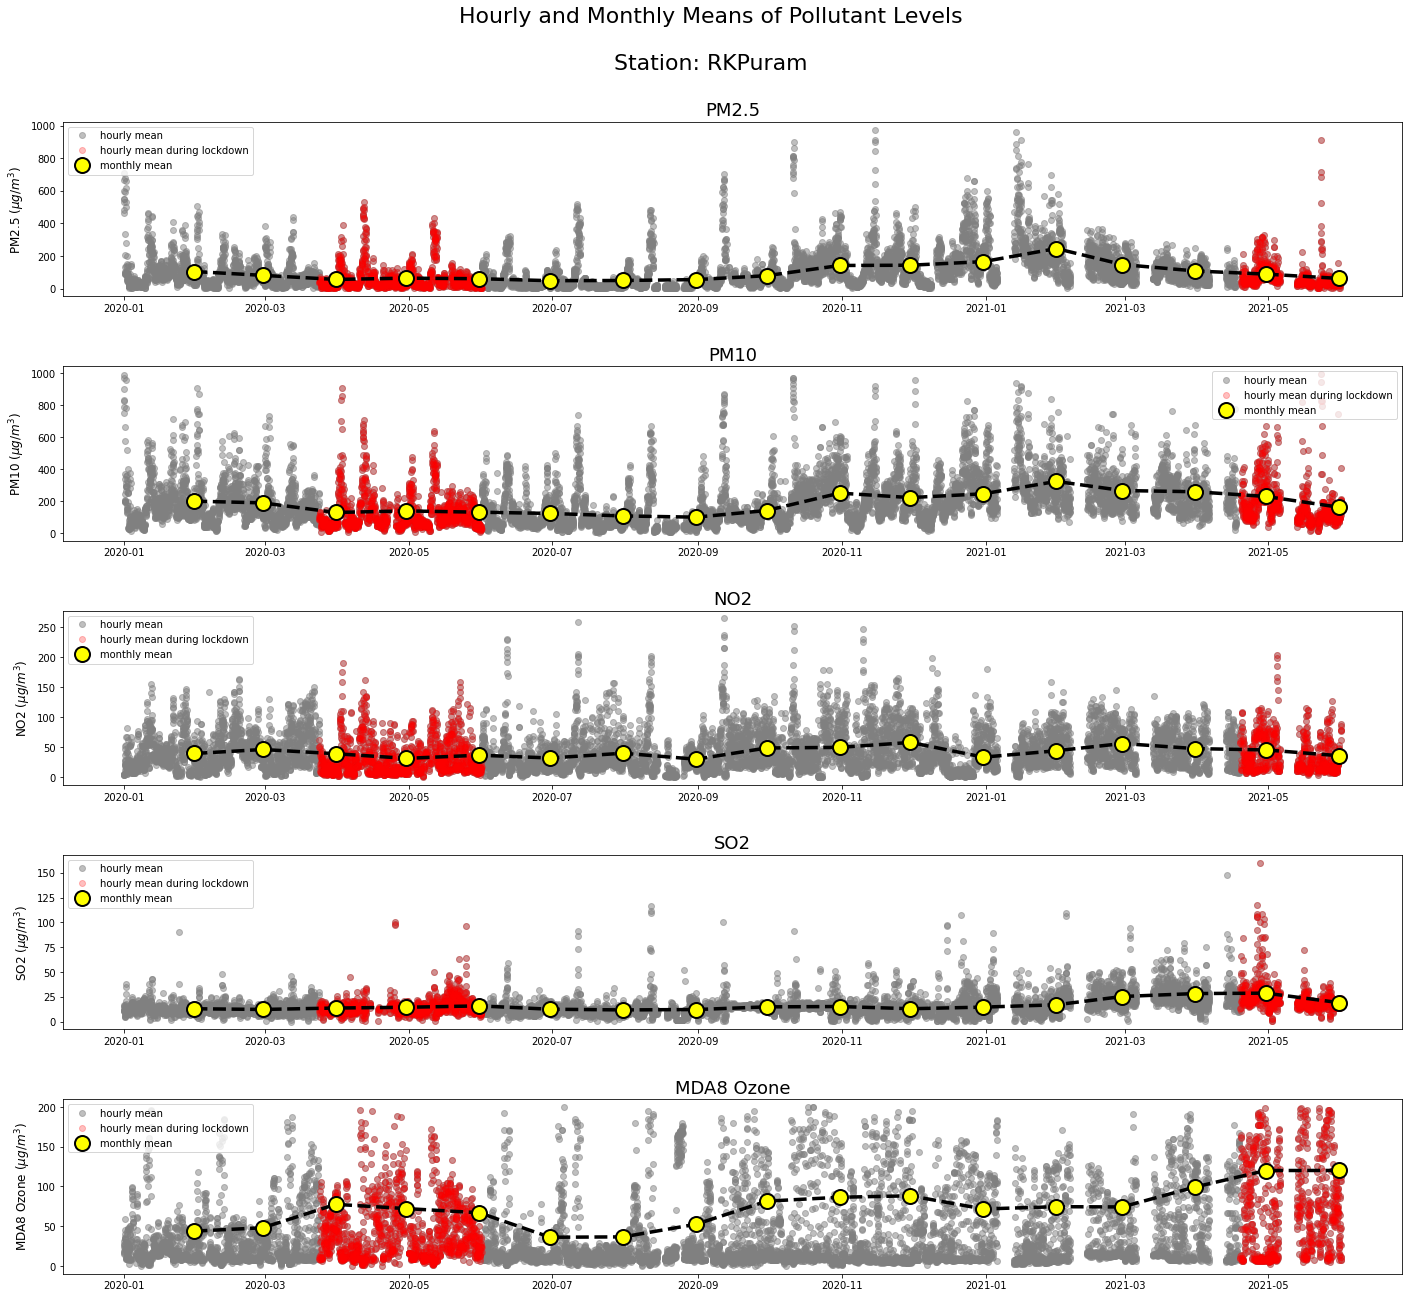

In [110]:
plotStationData('RKPuram')

## Box plots using dates from Singh et al

In [438]:
def makeBoxPlot(pollutant):
    
    accepted = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
    if pollutant not in accepted:
        print('Pollutant not valid. Options: PM2.5, PM10, NO2, SO2, and Ozone.')
        return
    
    daily_index = station_data['Alipur']['daily'].index
    df_daily = pd.DataFrame(index=daily_index)

    for station in station_data:
        if pollutant in station_data[station]['daily'].columns:
            df_daily[station] = station_data[station]['daily'][pollutant]

    avgs = [[], []]
    for station in df_daily.columns:
        avgs[0].append(at_least_one(df_daily[station]['2020-03-22':'2020-03-31']))
        avgs[1].append(at_least_one(df_daily[station]['2020-03-01':'2020-03-31']))

    avgs[0] = [x for x in avgs[0] if math.isnan(x) == False]
    avgs[1] = [x for x in avgs[1] if math.isnan(x) == False]

    if pollutant == 'Ozone':
        pollutant = 'MDA8 Ozone'
        
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.boxplot(avgs)
    ax.set_title(pollutant + ' Over Delhi\nPeak Lockdown 2020 vs. March 2020')
    ax.set_ylabel(pollutant + ' $µg/m^3$', fontsize=14)
    ax.set_xlabel('Duration', fontsize=14)
    plt.xticks([1, 2], ['2020 March 22-31', '2020 March'])

    fig_title = pollutant + 'BoxPlot.tiff'
    # plt.savefig(fig_title, bbox_inches="tight")
    
    plt.show()

# Box plots of weekly averages surrounding 2020 lockdown period 

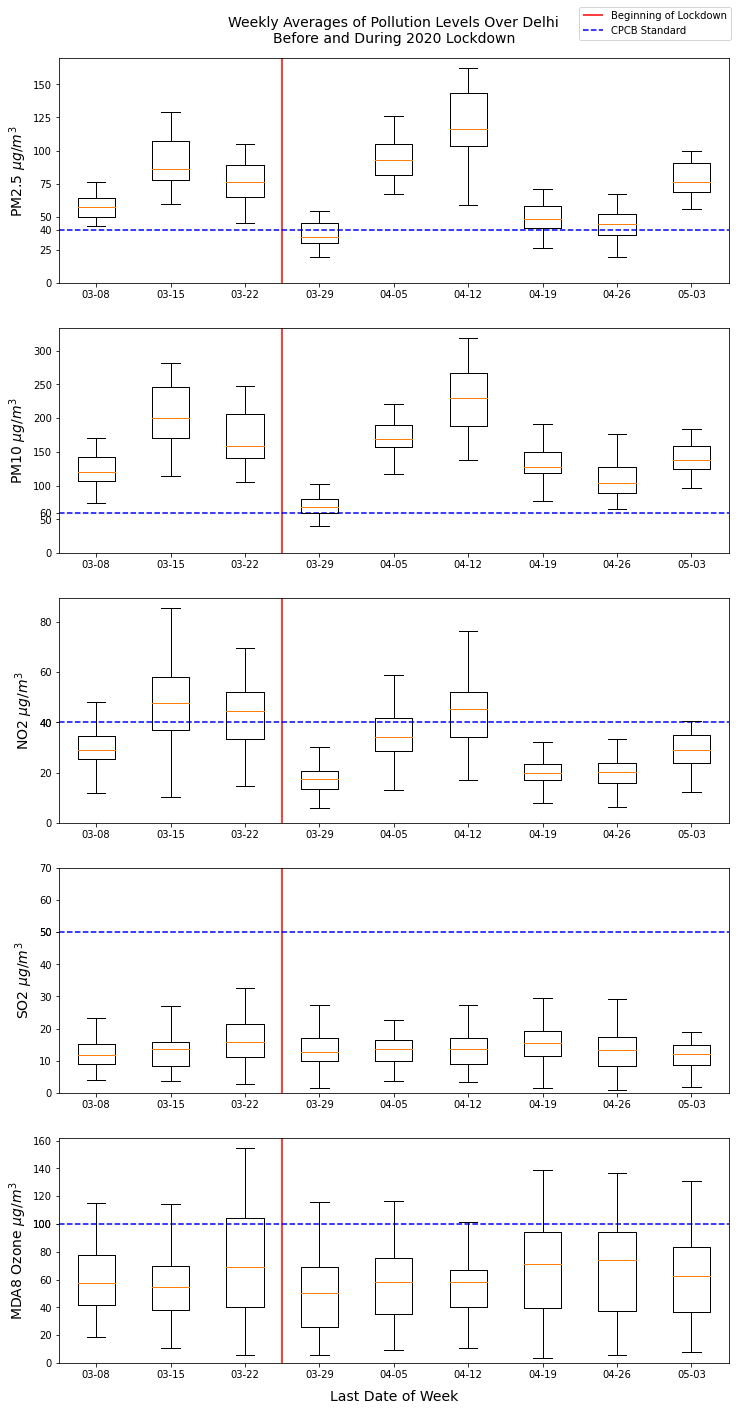

In [14]:
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
fig, axs = plt.subplots(5, figsize=(12, 24))

for i in range(5):
    avgs = defaultdict(list)
    for station in station_data:
        if pollutants[i] in station_data[station]['daily'].columns:
            daily_avgs = station_data[station]['daily'][pollutants[i]].loc['2020-03-02':'2020-05-03']
            weekly_avgs = daily_avgs.resample('W').apply(at_least_one)
            dates = weekly_avgs.index
            for date in dates:
                avgs[date].append(weekly_avgs[date])

    avgs_list = []
    for date in avgs:
        curr_list = [x for x in avgs[date] if math.isnan(x) == False]
        avgs_list.append(curr_list)

    if pollutants[i] == 'Ozone':
        pollutants[i] = 'MDA8 Ozone'

    axs[i].boxplot(avgs_list, showfliers=False)
    if pollutants[i] == 'PM2.5':
        axs[i].set_title('Weekly Averages of Pollution Levels Over Delhi\nBefore and During 2020 Lockdown', 
                         fontsize=14, pad=15)

    standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'MDA8 Ozone':100}
    
    top = axs[i].get_ylim()[1]
    if top < standards[pollutants[i]]:
        top = standards[pollutants[i]] + 20
    axs[i].vlines(x=3.5, ymin=0, ymax=top, color='r', linestyles='solid', 
                  label='Beginning of Lockdown')

    axs[i].hlines(y=standards[pollutants[i]], xmin=0.5, xmax=9.5, color='b', linestyles='dashed',
                  label='CPCB Standard')
    axs[i].set_yticks(list(axs[i].get_yticks()) + [standards[pollutants[i]]])
    axs[i].set_ylabel(pollutants[i] + ' $µg/m^3$', fontsize=14)
    axs[i].set_ylim(0, top)
    axs[i].set_xticks([r for r in range(1, len(dates)+1)])
    axs[i].set_xticklabels([str(d)[5:10] for d in dates])

    if pollutants[i] == 'PM2.5':
        axs[i].legend(bbox_to_anchor=(0.89, 1.25), loc='upper center')

fig_title = '2020_Lockdown_Weekly_Avg_Box_Plot.tiff'
plt.savefig(fig_title, bbox_inches="tight")

plt.xlabel('Last Date of Week', fontsize=14, labelpad=10)
plt.show()

# Box plots of weekly averages surrounding 2021 lockdown period 

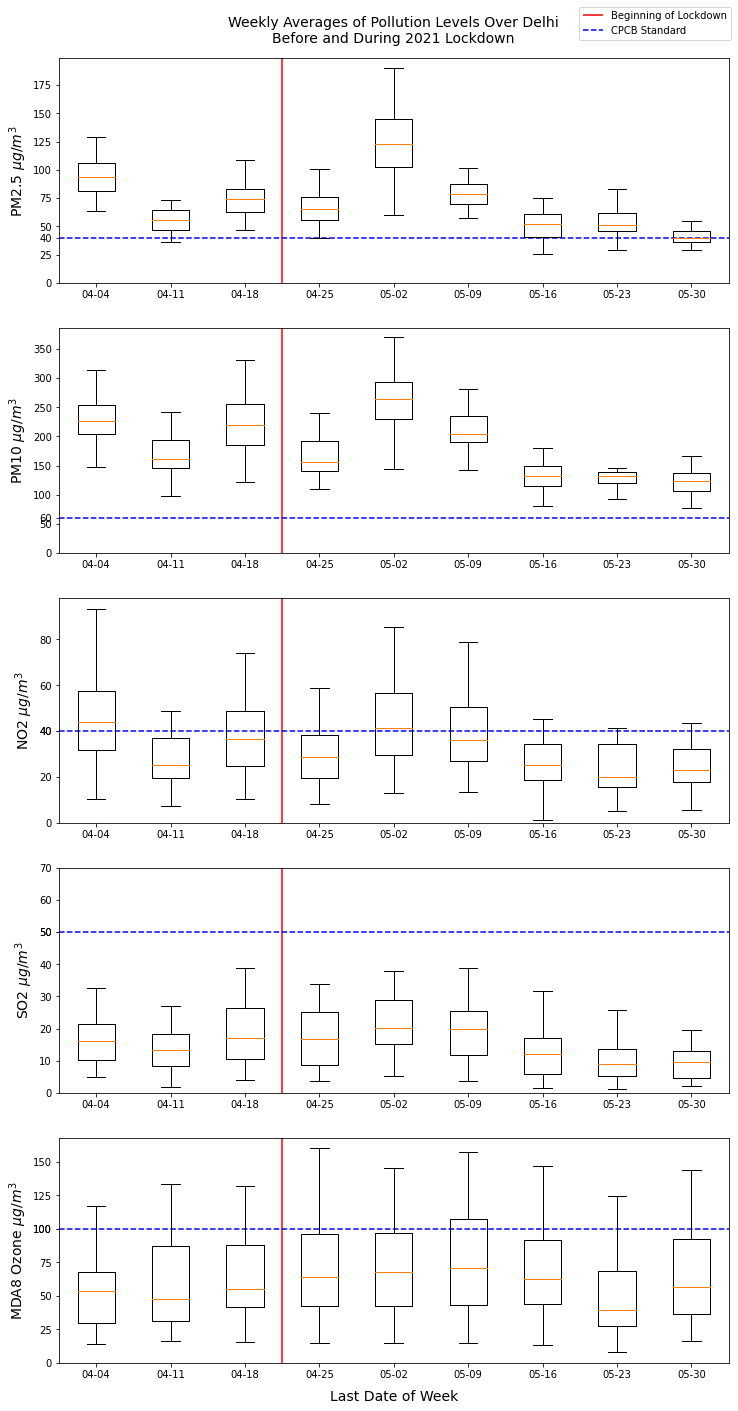

In [15]:
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
fig, axs = plt.subplots(5, figsize=(12, 24))

for i in range(5):
    avgs = defaultdict(list)
    for station in station_data:
        if pollutants[i] in station_data[station]['daily'].columns:
            daily_avgs = station_data[station]['daily'][pollutants[i]].loc['2021-03-29':'2021-05-30']
            weekly_avgs = daily_avgs.resample('W').apply(at_least_one)
            dates = weekly_avgs.index
            for date in dates:
                avgs[date].append(weekly_avgs[date])

    avgs_list = []
    for date in avgs:
        curr_list = [x for x in avgs[date] if math.isnan(x) == False]
        avgs_list.append(curr_list)

    if pollutants[i] == 'Ozone':
        pollutants[i] = 'MDA8 Ozone'

    axs[i].boxplot(avgs_list, showfliers=False)
    if pollutants[i] == 'PM2.5':
        axs[i].set_title('Weekly Averages of Pollution Levels Over Delhi\nBefore and During 2021 Lockdown', 
                         fontsize=14, pad=15)

    standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'MDA8 Ozone':100}

    top = axs[i].get_ylim()[1] 
    if top < standards[pollutants[i]]:
        top = standards[pollutants[i]] + 20
    axs[i].vlines(x=3.5, ymin=0, ymax=top, color='r', linestyles='solid', 
                  label='Beginning of Lockdown')
    axs[i].hlines(y=standards[pollutants[i]], xmin=0.5, xmax=9.5, color='b', linestyles='dashed',
                  label='CPCB Standard')
    axs[i].set_yticks(list(axs[i].get_yticks()) + [standards[pollutants[i]]])
    axs[i].set_ylabel(pollutants[i] + ' $µg/m^3$', fontsize=14)
    axs[i].set_ylim(0, top)
    axs[i].set_xticks([r for r in range(1, len(dates)+1)])
    axs[i].set_xticklabels([str(d)[5:10] for d in dates])

    if pollutants[i] == 'PM2.5':
        axs[i].legend(bbox_to_anchor=(0.89, 1.25), loc='upper center')

fig_title = '2021_Lockdown_Weekly_Avg_Box_Plot.tiff'
plt.savefig(fig_title, bbox_inches="tight")

plt.xlabel('Last Date of Week', fontsize=14, labelpad=10)
plt.show()

## Box plot 2020 lockdown weekly averages based on pollutant

In [33]:
def make2020WeeklyBoxPlot(pollutant):
    
    accepted = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
    if pollutant not in accepted:
        print('Pollutant not valid. Options: PM2.5, PM10, NO2, SO2, and Ozone.')
        return

    dates = ['2020-03-08',
             '2020-03-15',
             '2020-03-22',
             '2020-03-29',
             '2020-04-05',
             '2020-04-12',
             '2020-04-19',
             '2020-04-26',
             '2020-05-03']
    dates = pd.to_datetime(dates)
    avgs = {}
    for date in dates:
        avgs[date] = []

    max_y_val = 0
    for station in station_data:
        if pollutant in station_data[station]['daily'].columns:
            daily_avgs = station_data[station]['daily'][pollutant].loc['2020-03-02':'2020-05-03']
            weekly_avgs = daily_avgs.resample('W').apply(at_least_one)
            if max(weekly_avgs) > max_y_val:
                max_y_val = max(weekly_avgs)
            for date in dates:
                avgs[date].append(weekly_avgs[date])

    avgs_list = []
    for date in avgs:
        curr_list = [x for x in avgs[date] if math.isnan(x) == False]
        avgs_list.append(curr_list)
        
    if pollutant == 'Ozone':
        pollutant = 'MDA8 Ozone'
        
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.boxplot(avgs_list)
    ax.set_title(pollutant + ' Over Delhi\nWeekly Averages Before and During Lockdown', fontsize=14)
    ax.set_ylabel(pollutant + ' $µg/m^3$', fontsize=14)
    ax.set_xlabel('Last Date of Week', fontsize=14, labelpad=10)
    
    dates = ['2020-03-08',
             '2020-03-15',
             '2020-03-22',
             '2020-03-29',
             '2020-04-05',
             '2020-04-12',
             '2020-04-19',
             '2020-04-26',
             '2020-05-03']
    
    plt.axvline(x=3.5, color='r', label='Beginning of Lockdown Period')
    # plt.vlines(x=3.5, ymin=0, ymax=500, color='r', linestyles='solid', 
               # label='Beginning of Lockdown Period')
    standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'MDA8 Ozone':100}
    
    plt.hlines(y=standards[pollutant], xmin=0.5, xmax=9.5, color='b', linestyles='dashed',
               label='CPCB Standard')
    plt.xticks([r for r in range(1, len(dates)+1)], dates)
    plt.yticks(list(plt.yticks()[0]) + [standards[pollutant]])
    
    fig_title = pollutant + '_Weekly_Box_Plot.tiff'
    plt.savefig(fig_title, bbox_inches="tight")
    plt.legend(loc='upper right')
    plt.show()

# Box plots of levels during 2020 lockdown period compared to previous years 

In [443]:
def compareLockdown2020wBoxPlot(pollutant):
    
    accepted = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
    if pollutant not in accepted:
        print('Pollutant not valid. Options: PM2.5, PM10, NO2, SO2, and Ozone.')
        return
    
    daily_index = station_data['Alipur']['daily'].index
    df_daily = pd.DataFrame(index=daily_index)

    for station in station_data:
        if pollutant in station_data[station]['daily'].columns:
            df_daily[station] = station_data[station]['daily'][pollutant]

    avgs = {}
    for station in df_daily.columns:
        for i in range(4):
            start_date = str(2018 + i) + '-03-24'
            end_date = str(2018 + i) + '-05-03'
            if i in avgs:
                avgs[i].append(at_least_one(df_daily[station][start_date:end_date]))
            else:
                avgs[i] = [at_least_one(df_daily[station][start_date:end_date])]
           
    avgs_list = []
    for i in range(4):
        avgs[i] = [x for x in avgs[i] if math.isnan(x) == False]
        avgs_list.append(avgs[i])
        
    if pollutant == 'Ozone':
        pollutant = 'MDA8 Ozone'
        
    fig, ax = plt.subplots(figsize=(14, 9))
    bp = ax.boxplot(avgs_list)
    
    medians = []
    for medline in bp['medians']:
        linedata = medline.get_ydata()
        medians.append(linedata[0])
    upper_labels = [str(round(s, 2)) for s in medians]
    for tick in range(1, 5):
        ax.text(tick+0.25, medians[tick-1], upper_labels[tick-1], color=(0.992, 0.557, 0.259), fontsize=11)
    
    ax.set_title('Average Levels of ' + pollutant + ' from\nMarch 24-May 3 (Dates of 2020 Lockdown Period)')
    ax.set_ylabel(pollutant + ' $µg/m^3$', fontsize=14)
    ax.set_xlabel('Duration', fontsize=14)
    plt.xticks([x for x in range(1, 5)], [x for x in range(2018, 2022)])

    fig_title = pollutant + 'BoxPlot.tiff'
    # plt.savefig(fig_title, bbox_inches="tight")
    
    plt.show()

# Box plots of levels during 2021 lockdown period compared to previous years 

In [242]:
def compareLockdown2021wBoxPlot(pollutant):
    
    accepted = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
    if pollutant not in accepted:
        print('Pollutant not valid. Options: PM2.5, PM10, NO2, SO2, and Ozone.')
        return
    
    daily_index = station_data['Alipur']['daily'].index
    df_daily = pd.DataFrame(index=daily_index)

    for station in station_data:
        if pollutant in station_data[station]['daily'].columns:
            df_daily[station] = station_data[station]['daily'][pollutant]

    avgs = {}
    for station in df_daily.columns:
        for i in range(4):
            start_date = str(2018 + i) + '-04-19'
            end_date = str(2018 + i) + '-05-31'
            if i in avgs:
                avgs[i].append(at_least_one(df_daily[station][start_date:end_date]))
            else:
                avgs[i] = [at_least_one(df_daily[station][start_date:end_date])]
           
    avgs_list = []
    for i in range(4):
        avgs[i] = [x for x in avgs[i] if math.isnan(x) == False]
        avgs_list.append(avgs[i])
        
    if pollutant == 'Ozone':
        pollutant = 'MDA8 Ozone'
        
    fig, ax = plt.subplots(figsize=(14, 9))
    bp = ax.boxplot(avgs_list)
    
    medians = []
    for medline in bp['medians']:
        linedata = medline.get_ydata()
        medians.append(linedata[0])
    upper_labels = [str(round(s, 2)) for s in medians]
    for tick in range(1, 5):
        ax.text(tick+0.25, medians[tick-1], upper_labels[tick-1], color=(0.992, 0.557, 0.259), fontsize=11)
    
    ax.set_title('Average Levels of ' + pollutant + ' from\nApril 19-May 31 (Dates of 2021 Lockdown Period)')
    ax.set_ylabel(pollutant + ' $µg/m^3$', fontsize=14)
    ax.set_xlabel('Duration', fontsize=14)
    plt.xticks([x for x in range(1, 5)], [x for x in range(2018, 2022)])

    fig_title = pollutant + 'BoxPlot.tiff'
    # plt.savefig(fig_title, bbox_inches="tight")
    
    plt.show()

In [445]:
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']

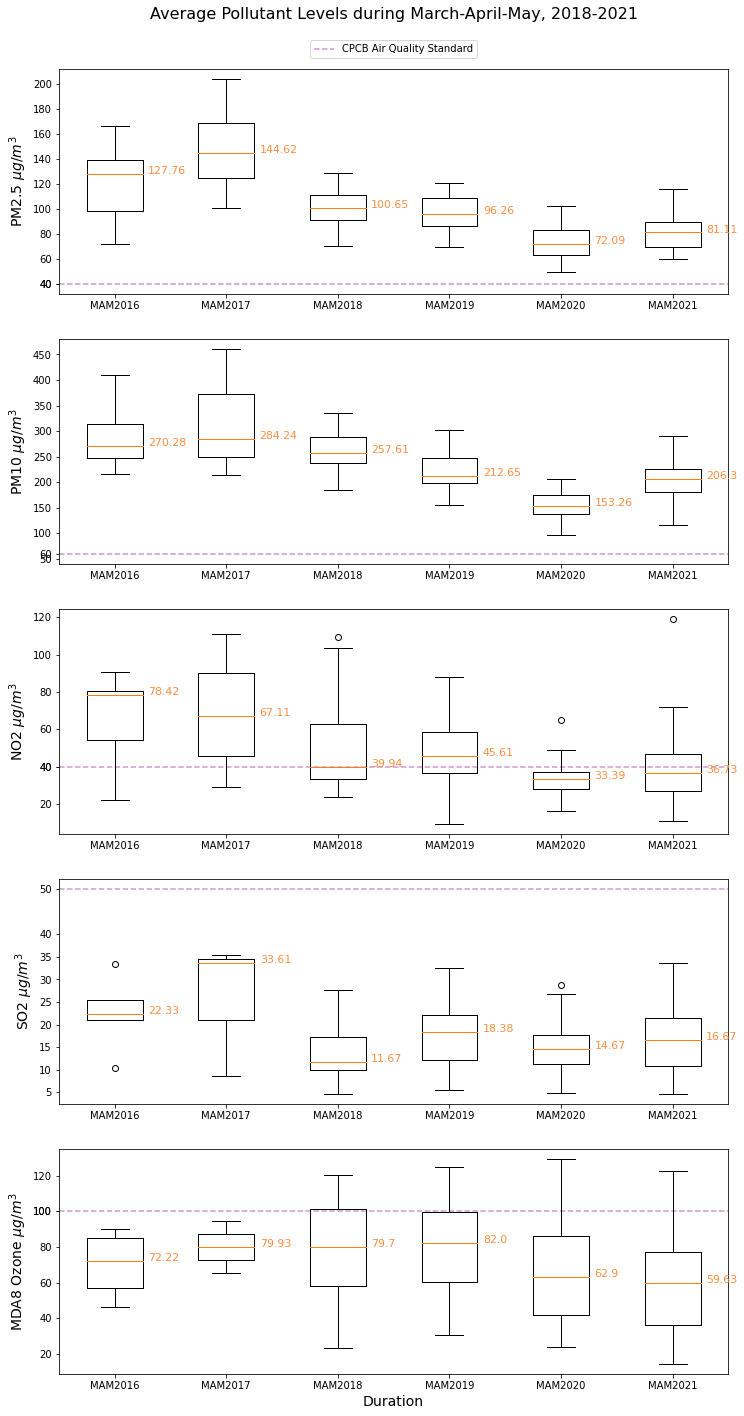

In [462]:
fig, axs = plt.subplots(5, figsize=(12, 24))
standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'MDA8 Ozone':100}

for pollutant, ax in zip(pollutants, axs):
    avgs = {}
    for station in station_data:
        if pollutant not in station_data[station]['seasonal'].columns:
            continue
        for i in range(6):
            season_index = 'MAM' + str(2016 + i)
            if i in avgs:
                avgs[i].append(station_data[station]['seasonal'][pollutant][season_index])
            else:
                avgs[i] = [station_data[station]['seasonal'][pollutant][season_index]]

    avgs_list = []
    for i in range(6):
        avgs[i] = [x for x in avgs[i] if math.isnan(x) == False]
        avgs_list.append(avgs[i])

    if pollutant == 'Ozone':
        pollutant = 'MDA8 Ozone'

    bp = ax.boxplot(avgs_list)

    medians = []
    for medline in bp['medians']:
        linedata = medline.get_ydata()
        medians.append(linedata[0])
    upper_labels = [str(round(s, 2)) for s in medians]
    for tick in range(1, 7):
        ax.text(tick+0.3, medians[tick-1], upper_labels[tick-1], color=(0.992, 0.557, 0.259), fontsize=11)

    # ax.set_title('Average Levels of ' + pollutant + ' from\nApril 19-May 31 (Dates of 2021 Lockdown Period)')
    ax.set_ylabel(pollutant + ' $µg/m^3$', fontsize=14)
    ax.set_yticks(list(ax.get_yticks()) + [standards[pollutant]])
    ax.set_xticks([x for x in range(1, 7)])
    ax.set_xticklabels([('MAM'+str(x)) for x in range(2016, 2022)])
    ax.hlines(y=standards[pollutant], xmin=0.5, xmax=6.5, color='purple', linestyles='dashed',
              alpha=0.4, label='CPCB Air Quality Standard')
    
    if pollutant == 'PM2.5':
        ax.set_title('Average Pollutant Levels during March-April-May, 2018-2021', fontsize=16, pad=50)
        ax.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center')

# plt.xticks([x for x in range(1, 7)], [('MAM'+str(x)) for x in range(2016, 2022)], fontsize=14)
plt.xlabel('Duration', fontsize=14)
#fig.suptitle('Average Pollutant Levels during March-April-May, 2018-2021', fontsize=18)
#fig.tight_layout(rect=[0, 0, 1, 0.97])

fig_title = 'MAMBoxPlot.tiff'
plt.savefig(fig_title, bbox_inches="tight")

plt.show()

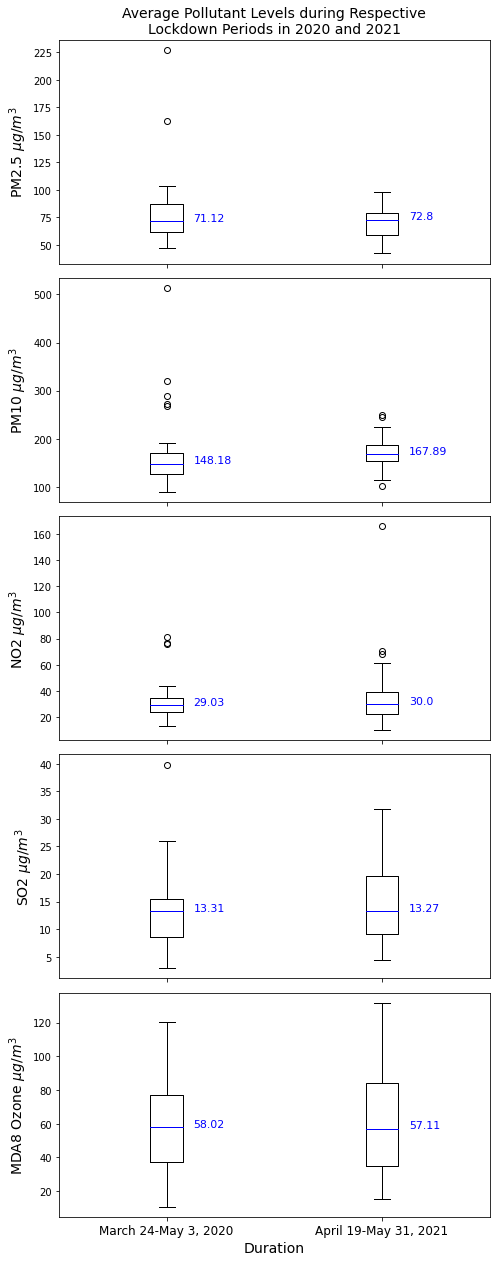

In [461]:
fig, axs = plt.subplots(5, figsize=(7, 18), sharex=True)

for pollutant, ax in zip(pollutants, axs):
    avgs_2020 = []
    avgs_2021 = []
    for station in station_data:
        if pollutant not in station_data[station]['daily'].columns:
            continue
        ld_mean_2020 = station_data[station]['daily'].loc['2020-03-24':'2020-05-03', pollutant].mean()
        ld_mean_2021 = station_data[station]['daily'].loc['2021-04-19':'2021-05-31', pollutant].mean()
        if not math.isnan(ld_mean_2020):
            avgs_2020.append(ld_mean_2020)
        if not math.isnan(ld_mean_2021):
            avgs_2021.append(ld_mean_2021)

    avgs_list = [avgs_2020, avgs_2021]

    if pollutant == 'Ozone':
        pollutant = 'MDA8 Ozone'

    medianprops = dict(color='blue')
    bp = ax.boxplot(avgs_list, medianprops=medianprops)

    medians = []
    for medline in bp['medians']:
        linedata = medline.get_ydata()
        medians.append(linedata[0])
    upper_labels = [str(round(s, 2)) for s in medians]
    for tick in range(1, 3):
        ax.text(tick+0.125, medians[tick-1], upper_labels[tick-1], color='blue', fontsize=11)

    # ax.set_title('Average Levels of ' + pollutant + ' from\nApril 19-May 31 (Dates of 2021 Lockdown Period)')
    ax.set_ylabel(pollutant + ' $µg/m^3$', fontsize=14)
    ax.set_xticks([])
    
    if pollutant == 'PM2.5':
        ax.set_title('Average Pollutant Levels during Respective\n' +
                     'Lockdown Periods in 2020 and 2021', fontsize=14)

plt.xticks([x for x in range(1, 3)], ['March 24-May 3, 2020', 'April 19-May 31, 2021'], fontsize=12)
plt.xlabel('Duration', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.98])
fig_title = 'Lockdown20and21BoxPlot.tiff'
plt.savefig(fig_title, bbox_inches="tight")

plt.show()

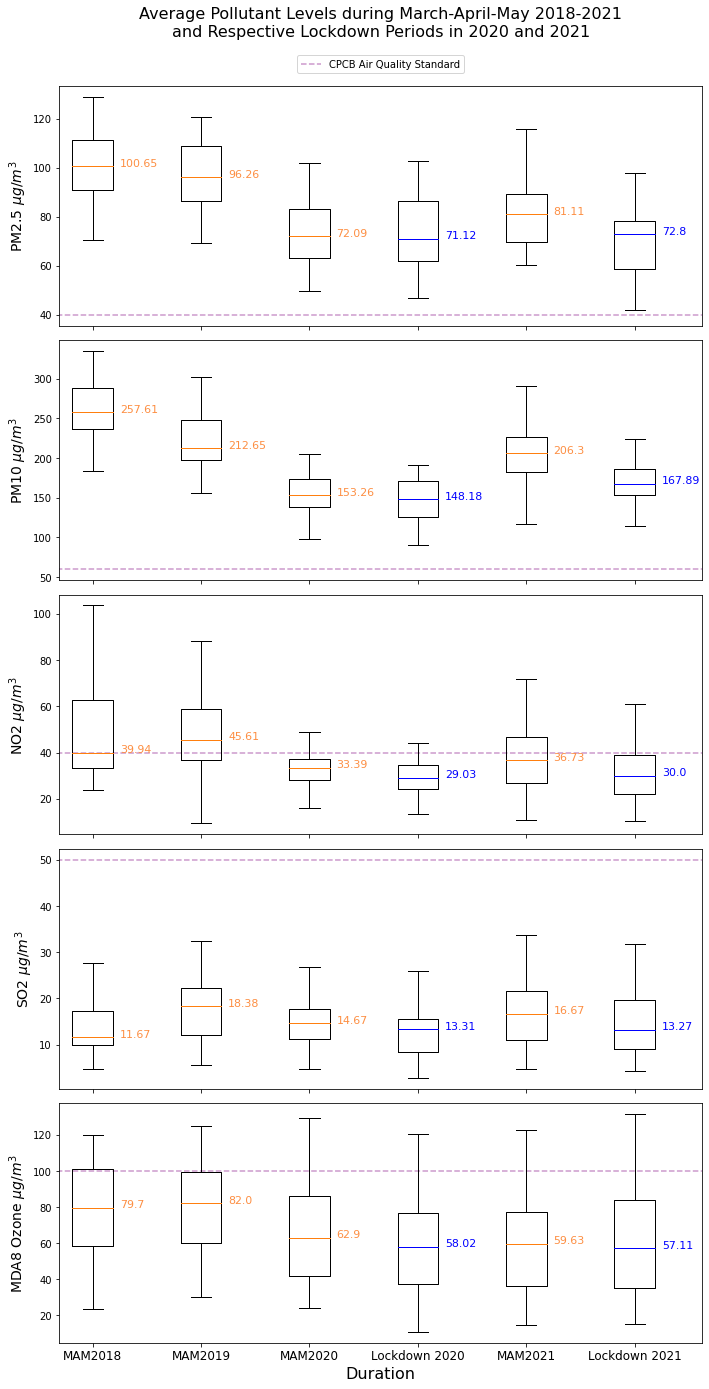

In [464]:
standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'MDA8 Ozone':100}
fig, axs = plt.subplots(5, figsize=(10, 20), sharex=True)

for pollutant, ax in zip(pollutants, axs):
    avgs = {}
    for station in station_data:
        if pollutant not in station_data[station]['seasonal'].columns:
            continue
        for i in range(4):
            season_index = 'MAM' + str(2018 + i)
            if i in avgs:
                avgs[i].append(station_data[station]['seasonal'][pollutant][season_index])
            else:
                avgs[i] = [station_data[station]['seasonal'][pollutant][season_index]]

    avgs_2020 = []
    avgs_2021 = []
    for station in station_data:
        if pollutant not in station_data[station]['daily'].columns:
            continue
        ld_mean_2020 = station_data[station]['daily'].loc['2020-03-24':'2020-05-03', pollutant].mean()
        ld_mean_2021 = station_data[station]['daily'].loc['2021-04-19':'2021-05-31', pollutant].mean()
        if not math.isnan(ld_mean_2020):
            avgs_2020.append(ld_mean_2020)
        if not math.isnan(ld_mean_2021):
            avgs_2021.append(ld_mean_2021)
                
    avgs_list = []
    for i in range(4):
        avgs[i] = [x for x in avgs[i] if math.isnan(x) == False]
        avgs_list.append(avgs[i])
        
    avgs_list.append(avgs_2020)
    avgs_list.append(avgs_2021)
        
    if pollutant == 'Ozone':
        pollutant = 'MDA8 Ozone'

    pos1 = [0.5, 1.3, 2.1, 3.7]
    pos2 = [2.9, 4.5]
    pos = [0.5, 1.3, 2.1, 2.9, 3.7, 4.5]
        
    widths = [0.3] * 4
    medianprops = dict(color='blue')
    bp1 = ax.boxplot(avgs_list[:4], widths=widths, positions=pos1, showfliers=False)
    bp2 = ax.boxplot(avgs_list[4:], widths=[0.3, 0.3], positions=pos2, medianprops=medianprops, showfliers=False)
    
    medians1 = []
    for medline in bp1['medians']:
        linedata = medline.get_ydata()
        medians1.append(linedata[0])
    upper_labels = [str(round(s, 2)) for s in medians1]
    for i in range(4):
        ax.text(pos1[i]+0.2, medians1[i], upper_labels[i], color=(0.992, 0.557, 0.259), fontsize=11)
    
    medians2 = []
    for medline in bp2['medians']:
        linedata = medline.get_ydata()
        medians2.append(linedata[0])
    upper_labels = [str(round(s, 2)) for s in medians2]
    for i in range(2):
        ax.text(pos2[i]+0.2, medians2[i], upper_labels[i], color='blue', fontsize=11)

    ax.set_ylabel(pollutant + ' $µg/m^3$', fontsize=14)
    ax.set_xlim((0.25, 5))
    ax.hlines(y=standards[pollutant], xmin=0, xmax=5, color='purple', linestyles='dashed',
              alpha=0.4, label='CPCB Air Quality Standard')
    
    if pollutant == 'PM2.5':
        ax.set_title('Average Pollutant Levels during March-April-May 2018-2021\n' + 
                     'and Respective Lockdown Periods in 2020 and 2021', fontsize=16, pad=50)
        ax.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center')
  
names = ['MAM2018', 'MAM2019', 'MAM2020', 'Lockdown 2020', 'MAM2021', 'Lockdown 2021']
plt.xticks(pos, names, fontsize=12)
plt.xlabel('Duration', fontsize=16)
# fig.suptitle('Average Pollutant Levels during March-April-May 2018-2021\n' + 
             # 'and Respective Lockdown Periods in 2020 and 2021', fontsize=16)

fig.tight_layout(rect=[0, 0, 1, 0.97])
fig_title = 'MAMandLDBoxPlot.tiff'
plt.savefig(fig_title, bbox_inches="tight")

plt.show()

# Plotting data averaged across all stations

## Averaging data across all stations for each pollutant

In [19]:
# AVERAGE VALUES ACROSS ALL STATIONS FOR EACH SPECIES
# STORE DATAFRAMES IN DICTIONARY 'holistic'

holistic = {}
time_levels = ['hourly', 'daily', 'monthly', 'seasonal', 'yearly']

for time_level in time_levels:
    # use arbitrary station to get the list of datetime indices
    ts_index = station_data['Alipur'][time_level].index

    # initialize df's for summarizing species data across stations
    pm25 = pd.DataFrame(index=ts_index)
    pm10 = pd.DataFrame(index=ts_index)
    no2 = pd.DataFrame(index=ts_index)
    so2 = pd.DataFrame(index=ts_index)
    ozone = pd.DataFrame(index=ts_index)

    for station in station_data:
        df = station_data[station][time_level]
        cols = df.columns
        if 'PM2.5' in cols:
            pm25[station] = df['PM2.5']
        if 'PM10' in cols:
            pm10[station] = df['PM10']
        if 'NO2' in cols:
            no2[station] = df['NO2']
        if 'SO2' in cols:
            so2[station] = df['SO2']
        if 'Ozone' in cols:
            ozone[station] = df['Ozone']

    holistic[time_level] = {}
    holistic[time_level]['PM2.5'] = pm25.median(axis=1, skipna=True)
    holistic[time_level]['PM10'] = pm10.median(axis=1, skipna=True)
    holistic[time_level]['NO2'] = no2.median(axis=1, skipna=True)
    holistic[time_level]['SO2'] = so2.median(axis=1, skipna=True)
    holistic[time_level]['Ozone'] = ozone.median(axis=1, skipna=True)

## Plotting weekly averages of each pollutant near lockdown

In [ ]:
def compareWeeklyAverages2020(pollutant):
    
    fig, axs = plt.subplots(3, 2, figsize=(18, 10))
    dims = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
    years = ['2016', '2017', '2018', '2019', '2020', '2021']
    max_y = 0
    
    for i in range(len(years)):
        if pollutant == 'MDA8 Ozone':
            pollutant = 'Ozone'
        
        daily = holistic['daily'][pollutant].loc[years[i] + '-03-02':years[i] + '-05-03']
        weekly = daily.resample('W').mean()
        dates = []
        for date in weekly.index:
            dates.append(str(date)[5:10])

        standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'MDA8 Ozone':100}

        x = np.arange(0, len(weekly))
        weekly.index = x
        y = weekly
        m, b = np.polyfit(x, y, 1)

        dim1, dim2 = dims[i]
        m = round(m, 2)
        b = round(b, 2)
        equation = str(m) + 'x+' + str(b)
        
        # make the plot
        l1, = axs[dim1][dim2].plot(weekly[weekly.index[:4]], color='y', marker='o')
        l2, = axs[dim1][dim2].plot(weekly[weekly.index[3:]], color='r', marker='o')
        axs[dim1][dim2].plot(x, m*x + b, label=equation)
        axs[dim1][dim2].legend(loc='upper left')
        
        if pollutant == 'Ozone':
            pollutant = 'MDA8 Ozone'

        axs[dim1][dim2].set_xticks(x)
        axs[dim1][dim2].set_xticklabels(dates)
        if dim1 == 2:
            axs[dim1][dim2].set_xlabel('Last Date of Week', fontsize=14, labelpad=10)
        if dim2 == 0:
            axs[dim1][dim2].set_ylabel('$µg/m^3$', fontsize=14)
        axs[dim1][dim2].set_title(years[i], fontsize=14)
        
        if axs[dim1][dim2].get_ylim()[1] > max_y:
            max_y = axs[dim1][dim2].get_ylim()[1]
        
    fig.suptitle('Comparing Weekly Averages of\n' + pollutant + \
                 ' Levels Before and During 2020 Lockdown Dates', fontsize=16) 
    
    # fig_title = pollutant + '_Lockdown_Weekly_Averages_.tiff'
    # plt.savefig(fig_title, bbox_inches="tight")
    for dim1, dim2 in dims:
        axs[dim1][dim2].set_ylim(0, max_y)
        
    plt.subplots_adjust(bottom=-0.5)
    plt.show()

In [90]:
def compareWeeklyAverages2020(pollutant):
    
    fig, axs = plt.subplots(3, 2, figsize=(18, 10))
    dims = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
    years = ['2016', '2017', '2018', '2019', '2020', '2021']
    max_y = 0
    
    for i in range(len(years)):
        if pollutant == 'MDA8 Ozone':
            pollutant = 'Ozone'
        
        daily = holistic['daily'][pollutant].loc[years[i] + '-03-03':years[i] + '-04-28']
        weekly = daily.resample('7D').mean()
        dates = []
        for date in weekly.index:
            dates.append(str(date)[5:10])

        standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'MDA8 Ozone':100}

        x = np.arange(0, len(weekly))
        weekly.index = x
        y = weekly
        m, b = np.polyfit(x, y, 1)

        dim1, dim2 = dims[i]
        m = round(m, 2)
        b = round(b, 2)
        equation = str(m) + 'x+' + str(b)
        
        # make the plot
        l1, = axs[dim1][dim2].plot(weekly[weekly.index[:4]], color='y', marker='o', label='Before Lockdown')
        l2, = axs[dim1][dim2].plot(weekly[weekly.index[3:]], color='r', marker='o', label='During Lockdown')
        axs[dim1][dim2].plot(x, m*x + b, label=equation)
        axs[dim1][dim2].legend(loc='upper left')
        
        if pollutant == 'Ozone':
            pollutant = 'MDA8 Ozone'

        axs[dim1][dim2].set_xticks(x)
        axs[dim1][dim2].set_xticklabels(dates)
        if dim1 == 2:
            axs[dim1][dim2].set_xlabel('First Date of Week', fontsize=14, labelpad=10)
        if dim2 == 0:
            axs[dim1][dim2].set_ylabel('$µg/m^3$', fontsize=14)
        axs[dim1][dim2].set_title(years[i], fontsize=14)
        
        if axs[dim1][dim2].get_ylim()[1] > max_y:
            max_y = axs[dim1][dim2].get_ylim()[1]
        
    fig.suptitle('Comparing Weekly Averages of\n' + pollutant + \
                 ' Levels Before and During 2020 Lockdown Dates', fontsize=16) 
    
    fig_title = pollutant + '_Trendlines_2020_Lockdown_Dates.tiff'
    plt.savefig(fig_title, bbox_inches="tight")
    for dim1, dim2 in dims:
        axs[dim1][dim2].set_ylim(0, max_y+50)
        
    plt.subplots_adjust(bottom=-0.5)
    plt.show()

In [89]:
daily = holistic['daily']['PM2.5'].loc['2020-03-03':'2020-04-28']
weekly = daily.resample('7D').mean()
daily.loc['2020-03-03':'2020-03-09'].mean()
weekly

From Date
2020-03-03     44.400452
2020-03-10     86.685880
2020-03-17     73.822304
2020-03-24     31.807913
2020-03-31     92.428136
2020-04-07    114.121962
2020-04-14     45.519457
2020-04-21     42.556931
2020-04-28     51.032031
Freq: 7D, dtype: float64

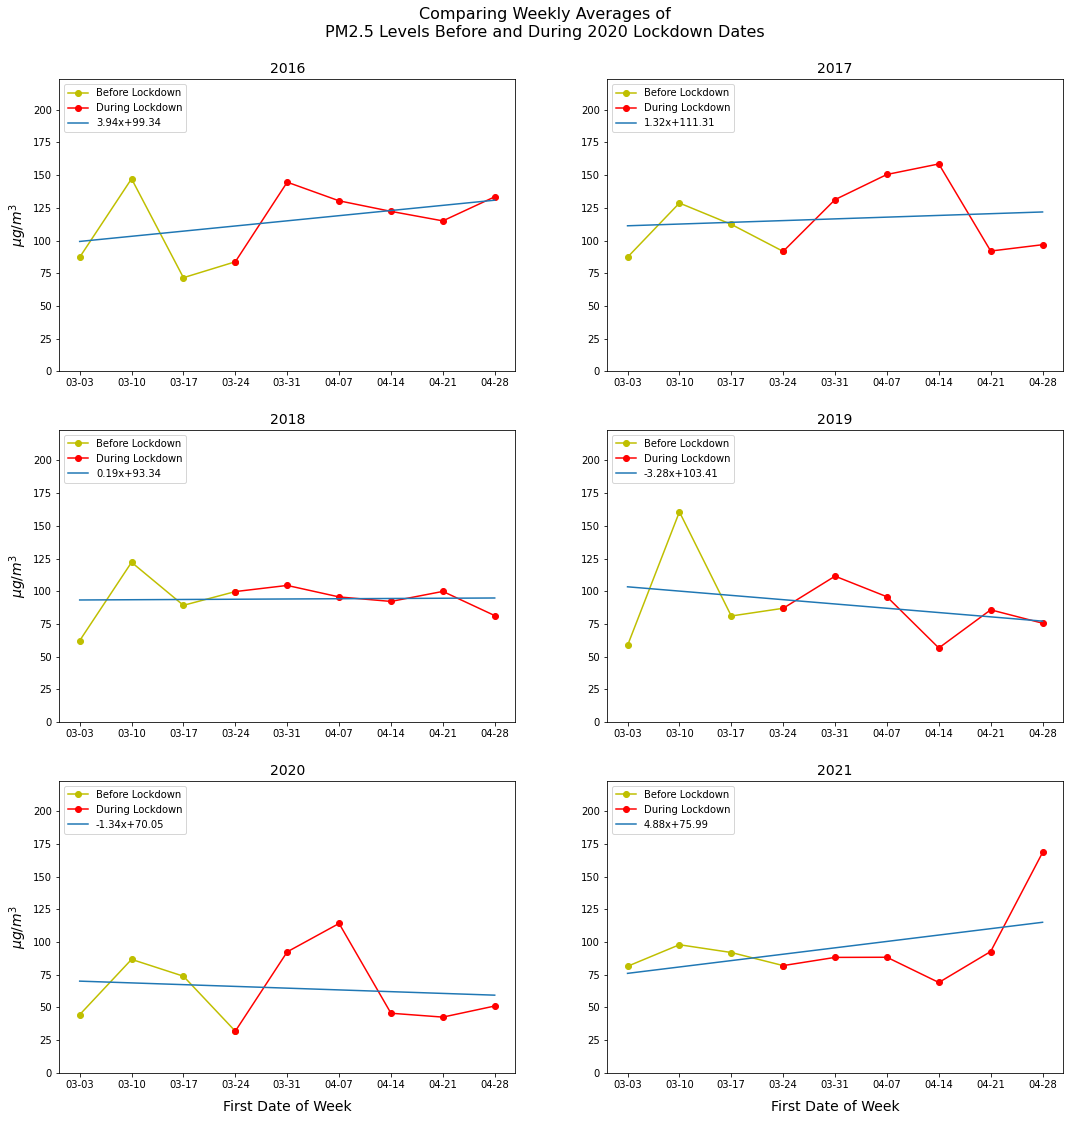

In [91]:
compareWeeklyAverages2020('PM2.5')

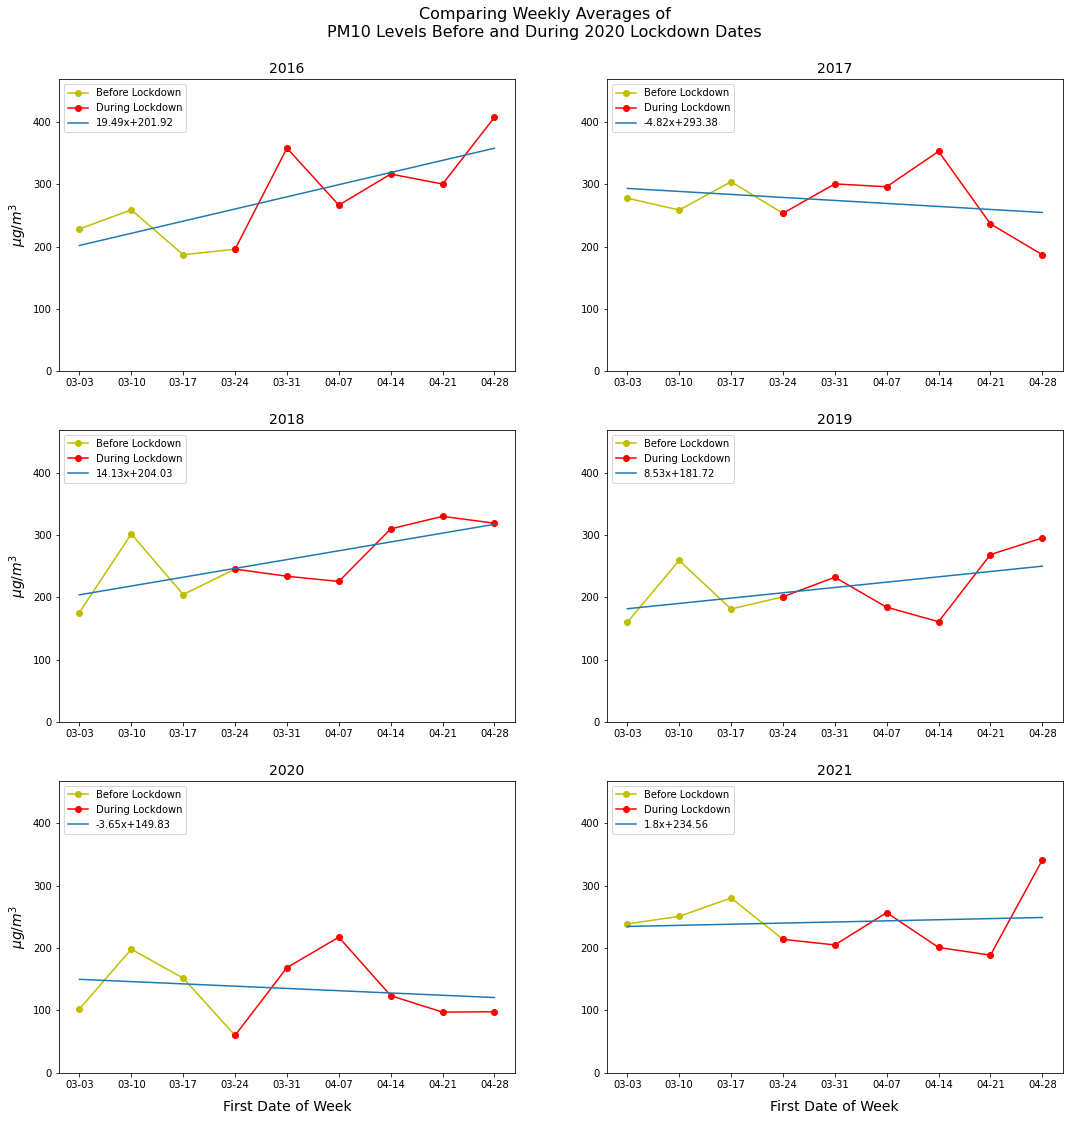

In [92]:
compareWeeklyAverages2020('PM10')

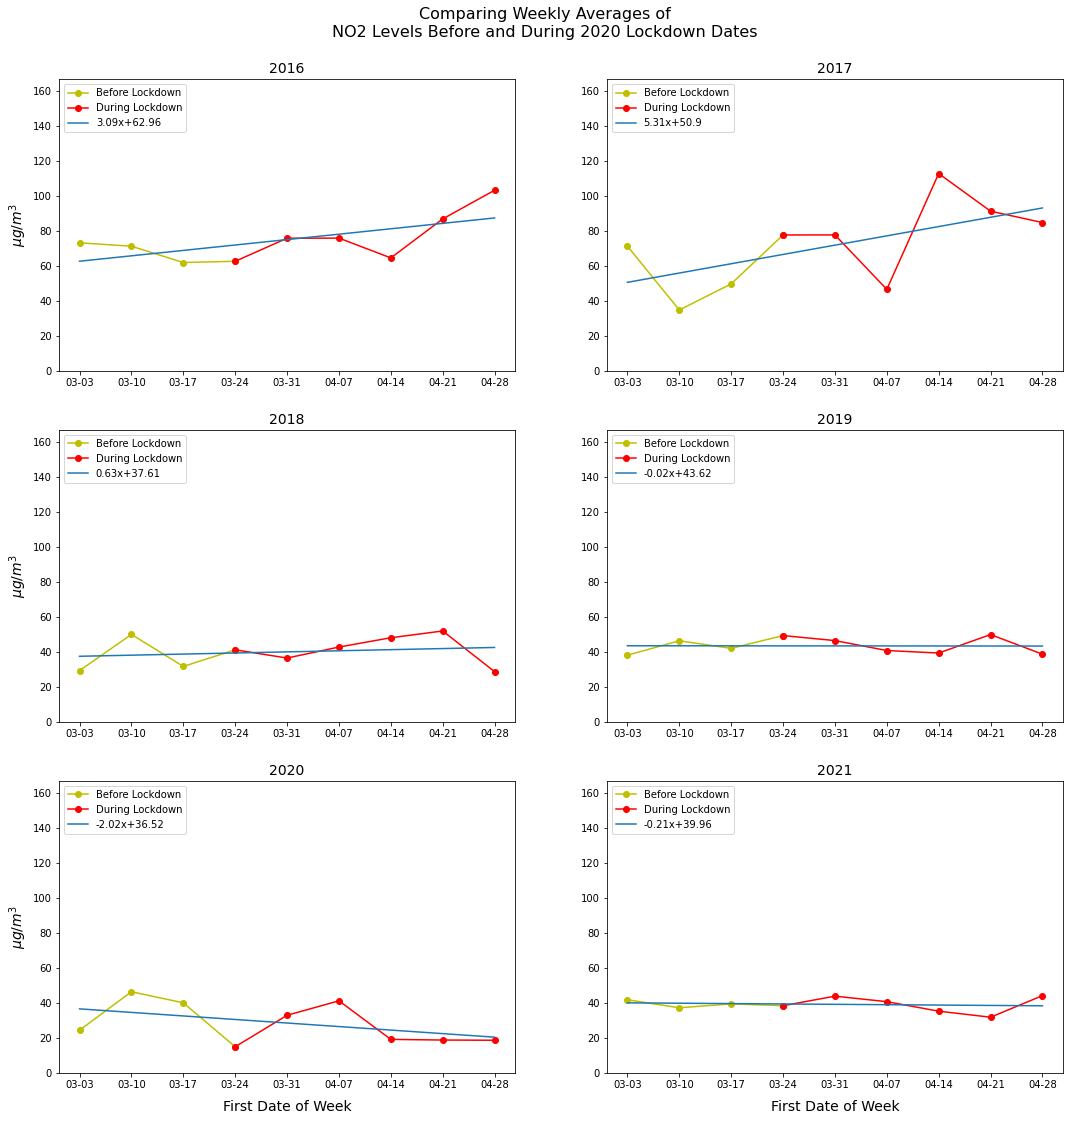

In [93]:
compareWeeklyAverages2020('NO2')

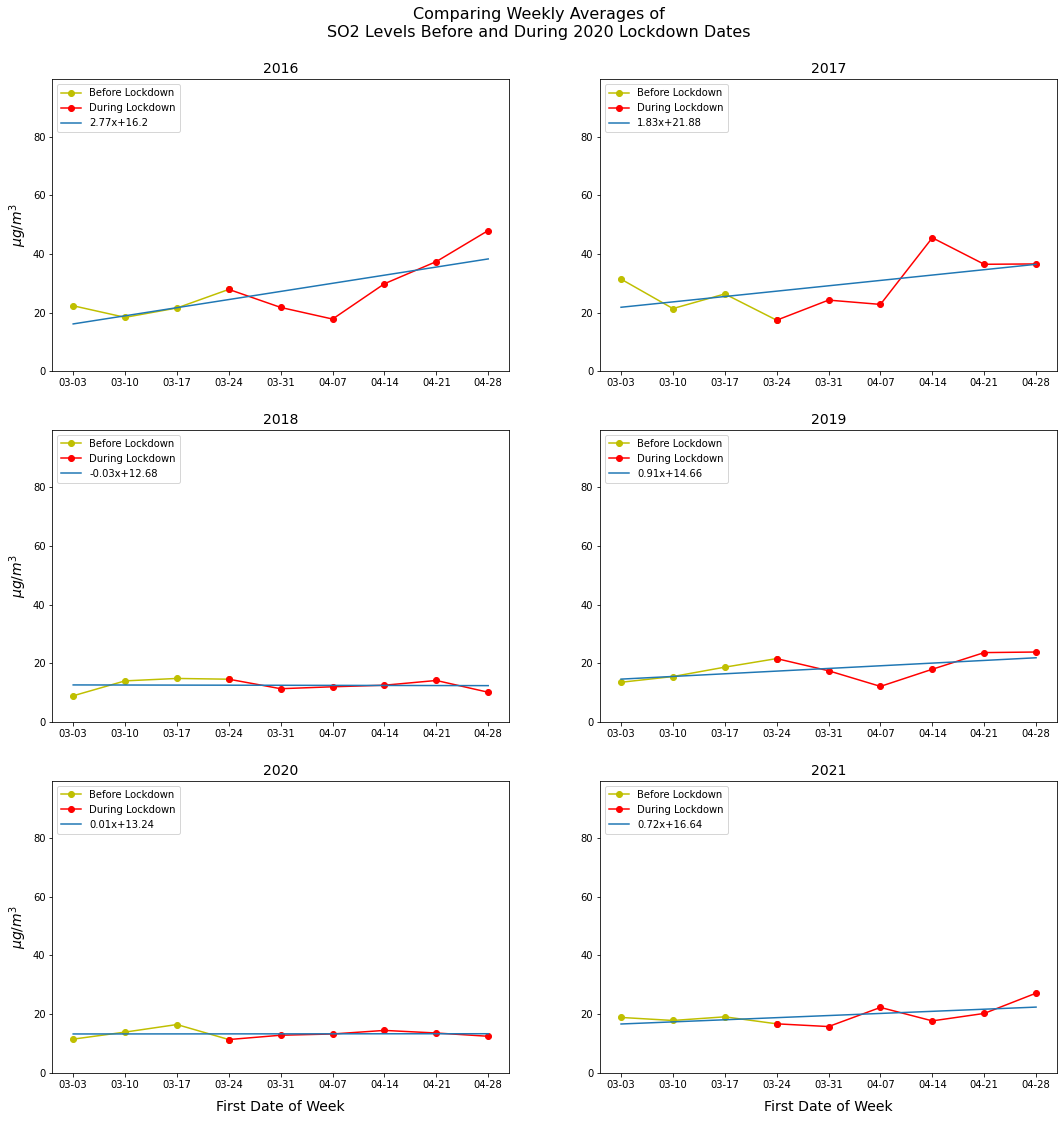

In [94]:
compareWeeklyAverages2020('SO2')

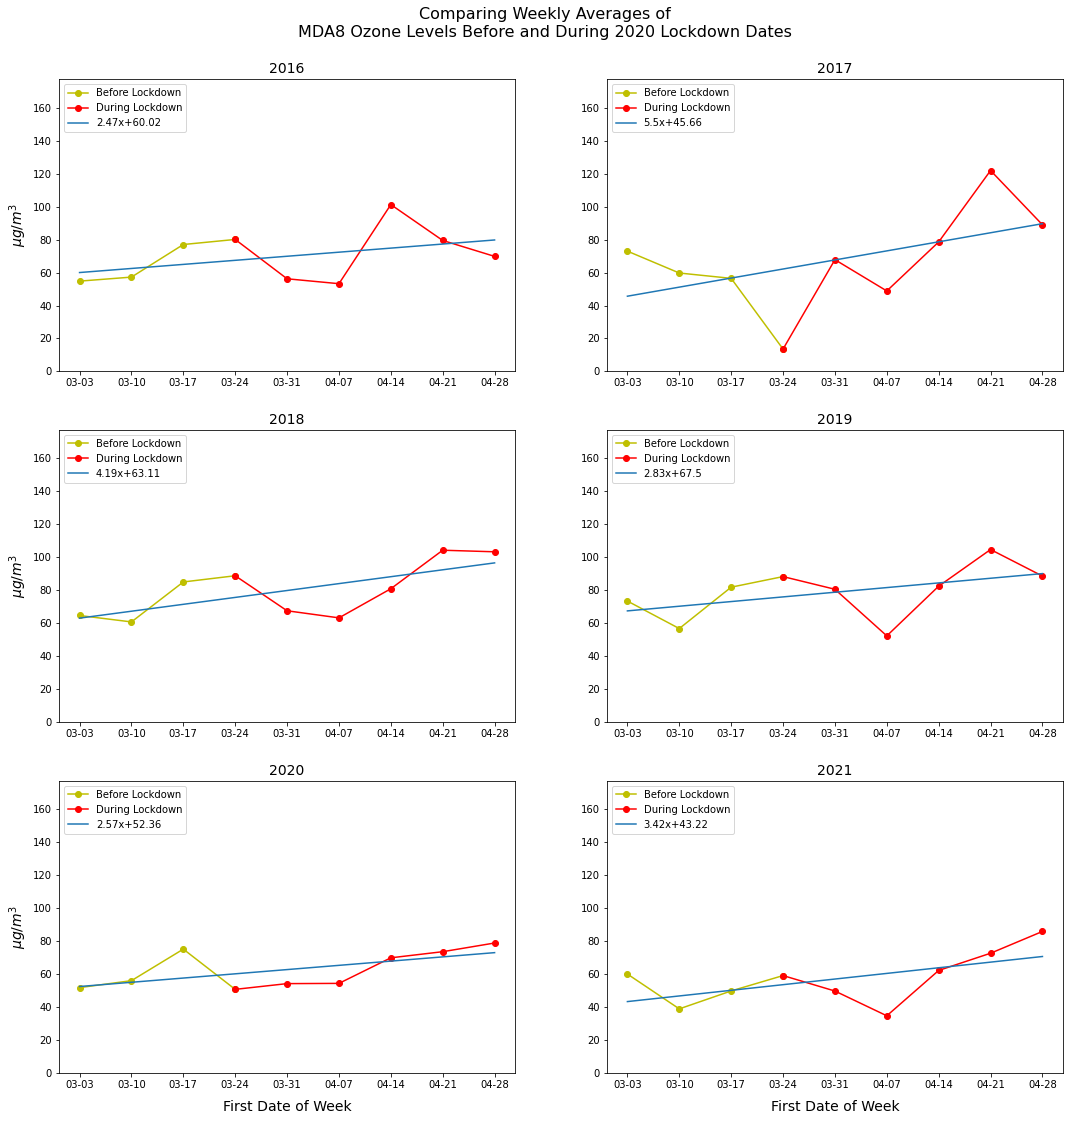

In [95]:
compareWeeklyAverages2020('Ozone')

In [96]:
def compareWeeklyAverages2021(pollutant):
    
    fig, axs = plt.subplots(3, 2, figsize=(18, 10))
    dims = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
    years = ['2016', '2017', '2018', '2019', '2020', '2021']
    max_y = 0
    
    for i in range(len(years)):
        if pollutant == 'MDA8 Ozone':
            pollutant = 'Ozone'
        
        daily = holistic['daily'][pollutant].loc[years[i] + '-03-29':years[i] + '-05-30']
        weekly = daily.resample('7D').mean()
        dates = []
        for date in weekly.index:
            dates.append(str(date)[5:10])

        standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'MDA8 Ozone':100}

        x = np.arange(0, len(weekly))
        weekly.index = x
        y = weekly
        m, b = np.polyfit(x, y, 1)

        dim1, dim2 = dims[i]
        m = round(m, 2)
        b = round(b, 2)
        equation = str(m) + 'x+' + str(b)
        
        # make the plot
        l1, = axs[dim1][dim2].plot(weekly[weekly.index[:4]], color='y', marker='o', label='Before Lockdown')
        l2, = axs[dim1][dim2].plot(weekly[weekly.index[3:]], color='r', marker='o', label='During Lockdown')
        axs[dim1][dim2].plot(x, m*x + b, label=equation)
        axs[dim1][dim2].legend(loc='upper left')
        
        if pollutant == 'Ozone':
            pollutant = 'MDA8 Ozone'

        axs[dim1][dim2].set_xticks(x)
        axs[dim1][dim2].set_xticklabels(dates)
        if dim1 == 2:
            axs[dim1][dim2].set_xlabel('First Date of Week', fontsize=14, labelpad=10)
        if dim2 == 0:
            axs[dim1][dim2].set_ylabel('$µg/m^3$', fontsize=14)
        axs[dim1][dim2].set_title(years[i], fontsize=14)
        
        if axs[dim1][dim2].get_ylim()[1] > max_y:
            max_y = axs[dim1][dim2].get_ylim()[1]
        
    fig.suptitle('Comparing Weekly Averages of\n' + pollutant + \
                 ' Levels Before and During 2021 Lockdown Dates', fontsize=16) 
    
    fig_title = pollutant + '_Trendlines_2021_Lockdown_Dates.tiff'
    plt.savefig(fig_title, bbox_inches="tight")
    for dim1, dim2 in dims:
        axs[dim1][dim2].set_ylim(0, max_y+50)
        
    plt.subplots_adjust(bottom=-0.5)
    plt.show()

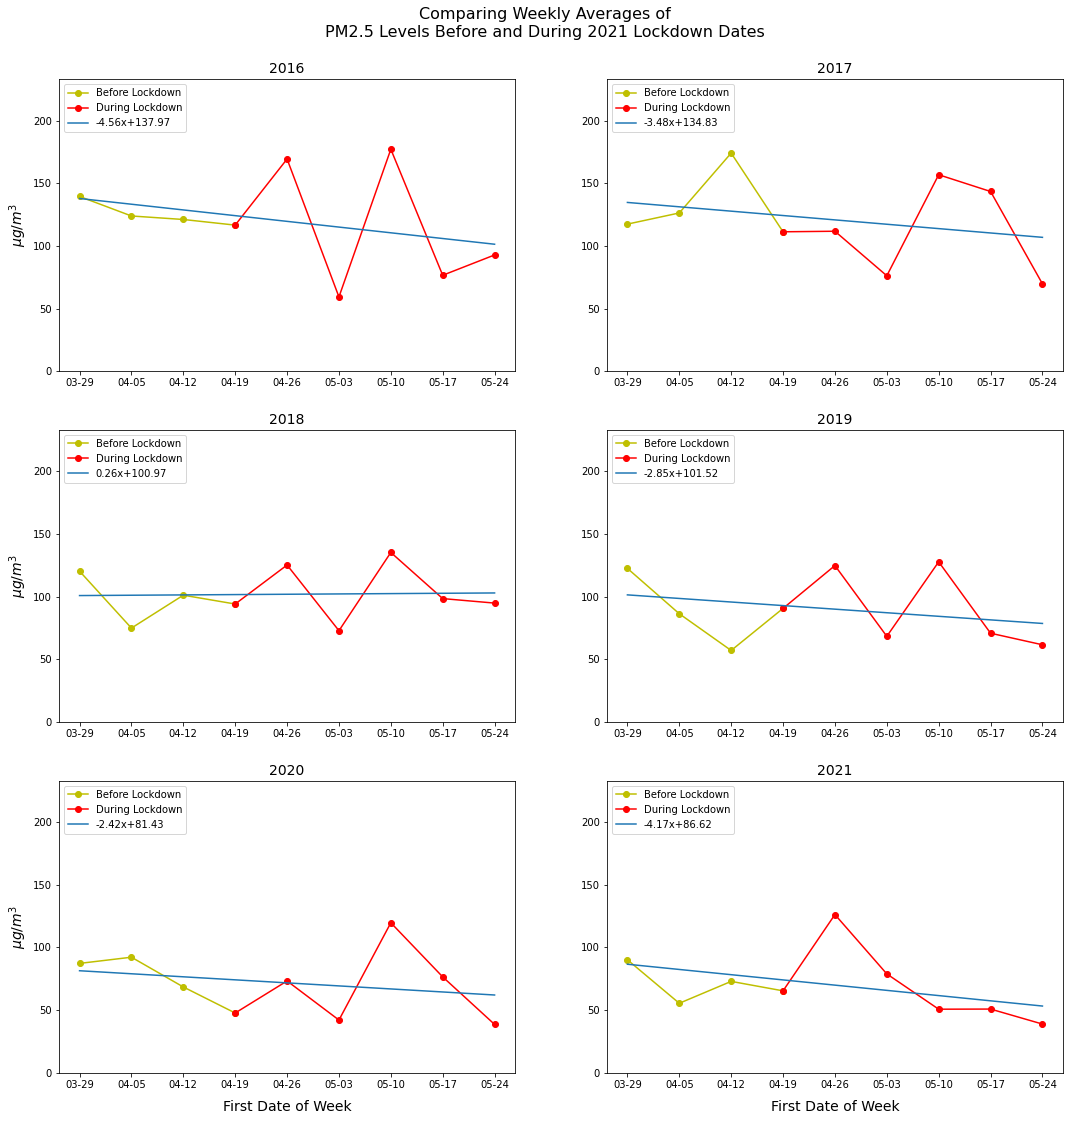

In [97]:
compareWeeklyAverages2021('PM2.5')

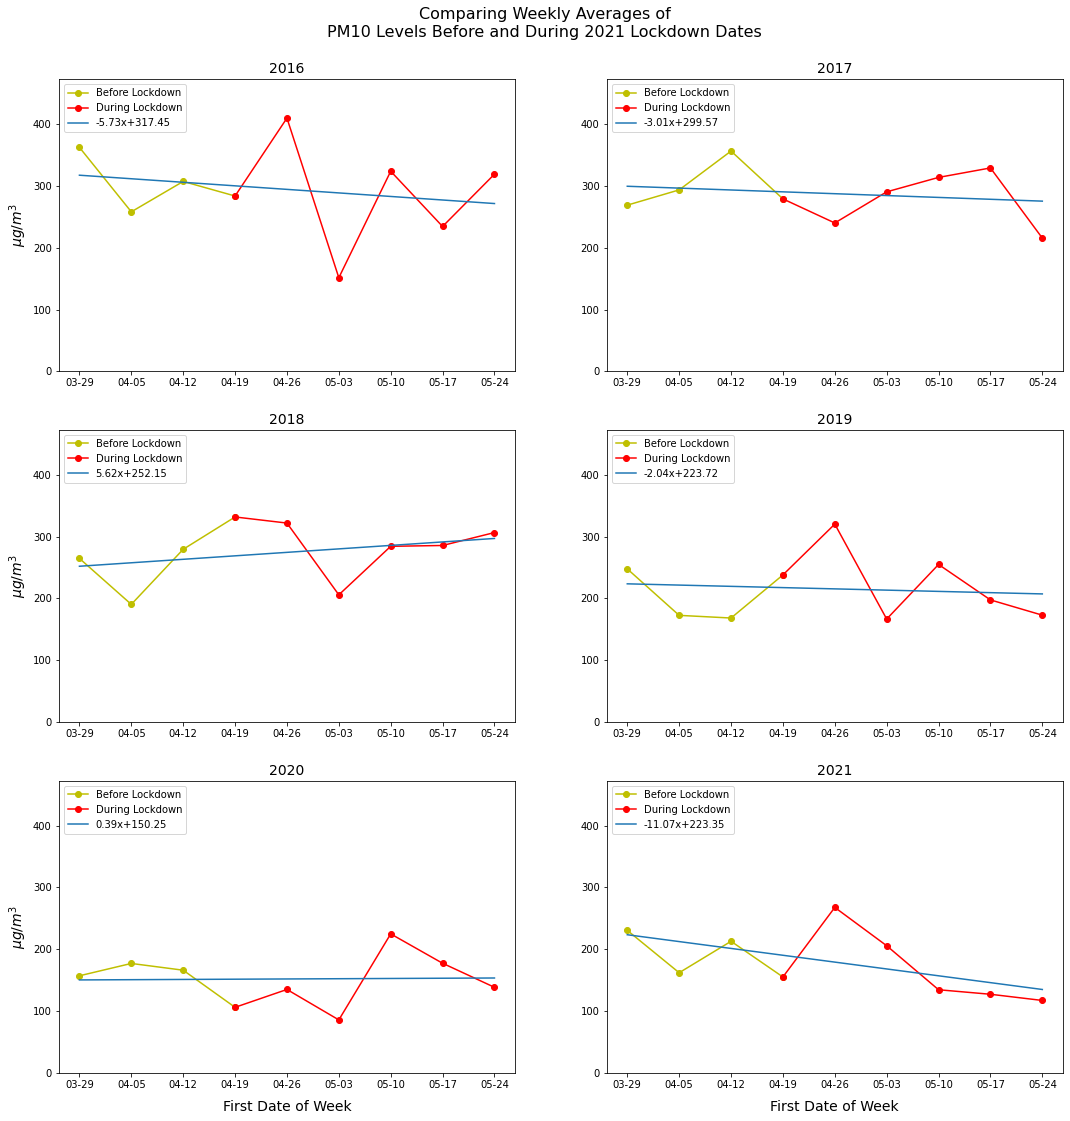

In [98]:
compareWeeklyAverages2021('PM10')

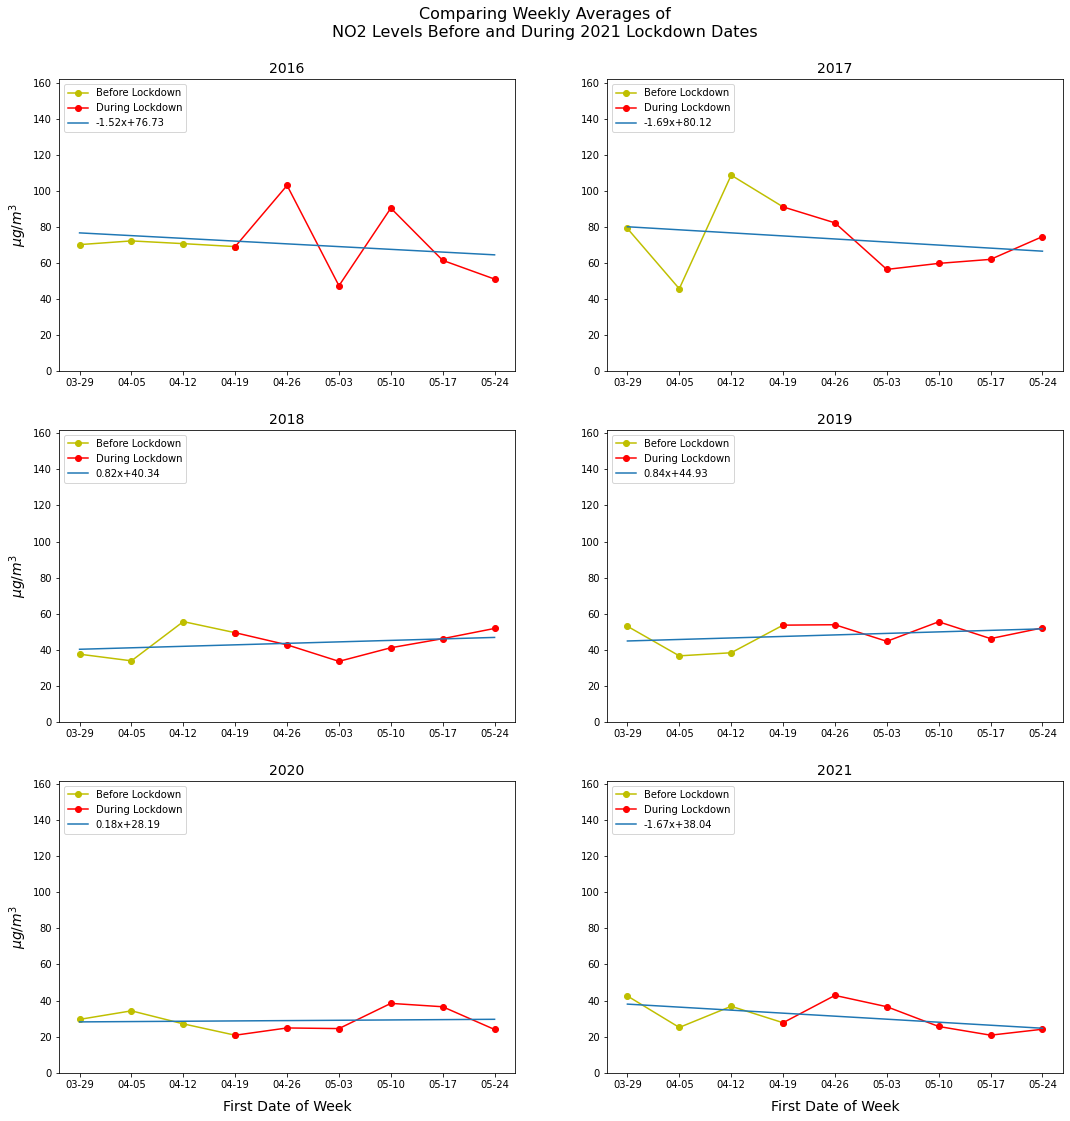

In [99]:
compareWeeklyAverages2021('NO2')

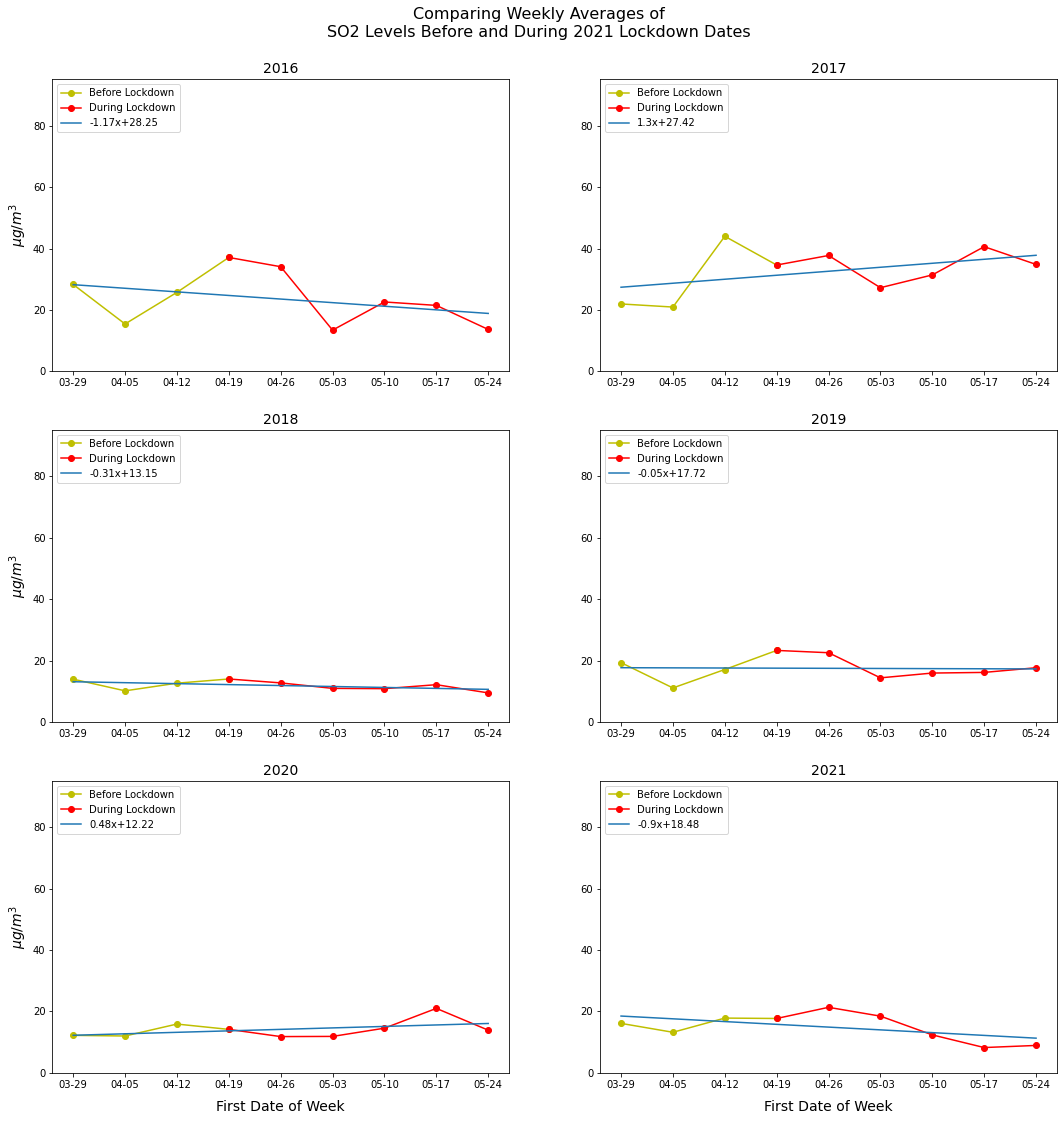

In [100]:
compareWeeklyAverages2021('SO2')

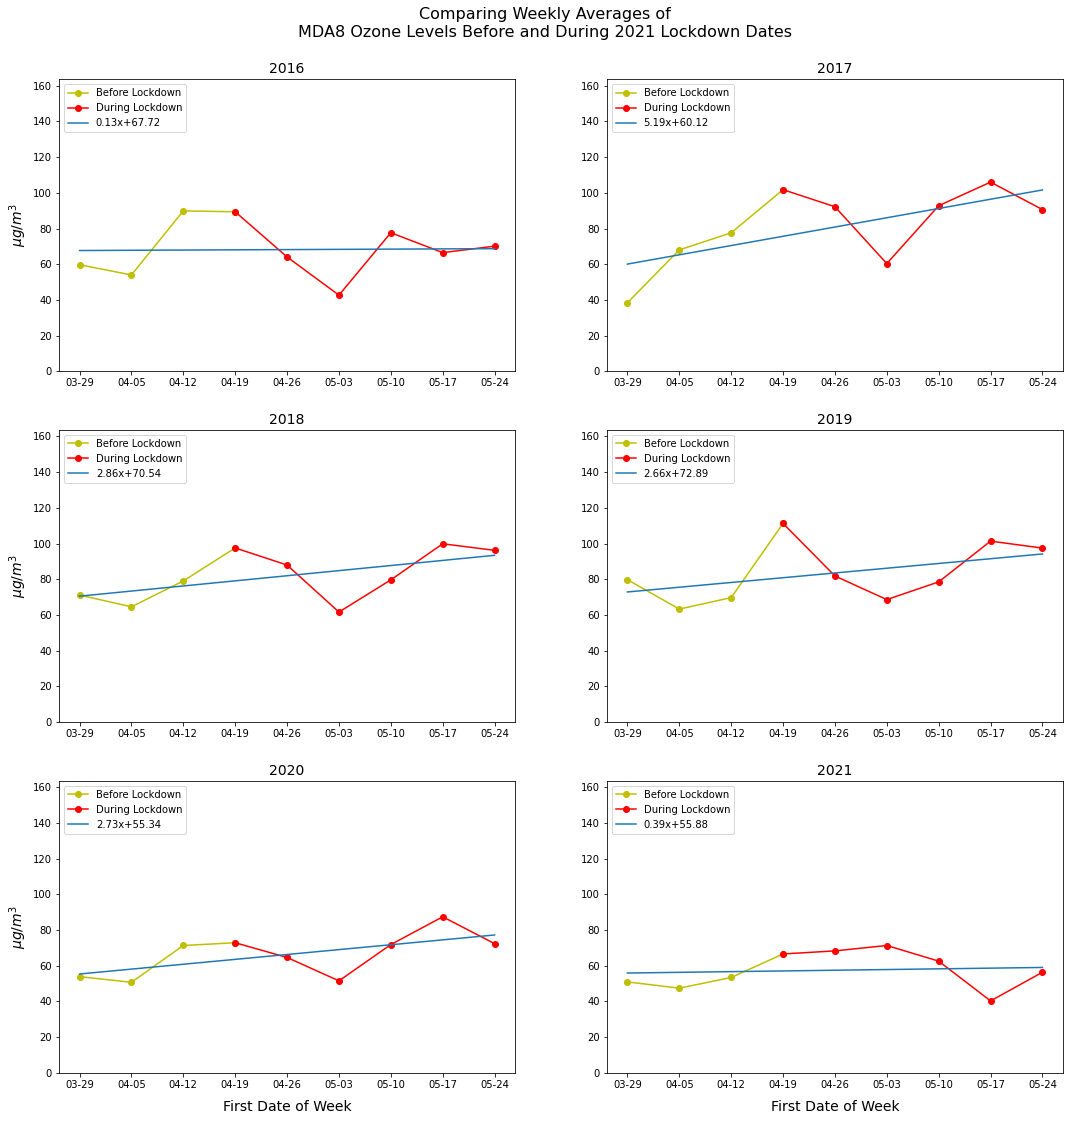

In [101]:
compareWeeklyAverages2021('Ozone')

# Recreating bar plots in Singh + Chauhan paper

In [40]:
# averages of species levels from March 22, 2020 - March 31, 2020
species_ld = [holistic['daily']['PM25'].loc['2020-03-22':'2020-03-31'].mean(),
              holistic['daily']['PM10'].loc['2020-03-22':'2020-03-31'].mean(),
              holistic['daily']['NO2'].loc['2020-03-22':'2020-03-31'].mean(),
              holistic['daily']['SO2'].loc['2020-03-22':'2020-03-31'].mean(),
              holistic['daily']['Ozone'].loc['2020-03-22':'2020-03-31'].mean()]

# March 2020 averages for each species
march_avgs = [holistic['monthly']['PM25'].loc['2020-03-31'],
              holistic['monthly']['PM10'].loc['2020-03-31'],
              holistic['monthly']['NO2'].loc['2020-03-31'],
              holistic['monthly']['SO2'].loc['2020-03-31'],
              holistic['monthly']['Ozone'].loc['2020-03-31']]

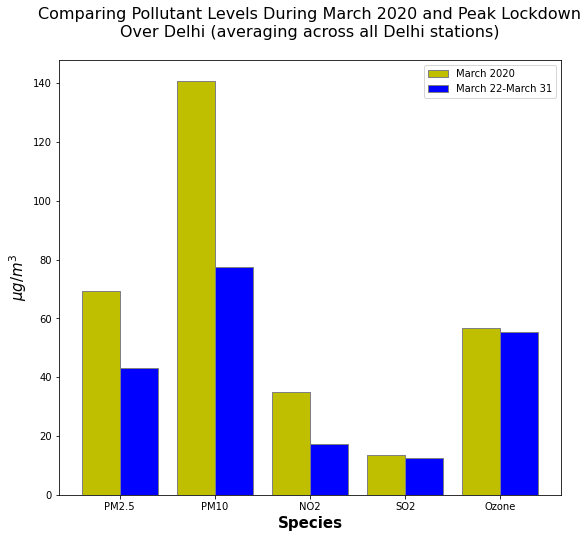

In [41]:
barWidth = 0.4
fig = plt.subplots(figsize =(9, 8))
 
# set position of bar on x-axis
br1 = np.arange(len(species_ld))
br2 = [x + barWidth for x in br1]
 
# make the plot
plt.bar(br1, march_avgs, color ='y', width = barWidth,
        edgecolor ='grey', label ='March 2020')
plt.bar(br2, species_ld, color ='b', width = barWidth,
        edgecolor ='grey', label ='March 22-March 31')

plt.xlabel('Species', fontweight ='bold', fontsize = 15)
plt.ylabel('$µg/m^3$', fontweight ='bold', fontsize = 15)
plt.xticks([r + (0.5*barWidth) for r in range(len(march_avgs))],
           ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone'])
plt.title('Comparing Pollutant Levels During March 2020 and Peak Lockdown\n' +
          'Over Delhi (averaging across all Delhi stations)\n', fontsize=16) 
plt.legend()
fig_title = 'Holistic_Lockdown_Comparison.tiff'
plt.savefig(fig_title, bbox_inches="tight")
plt.show()

# Plot hourly and monthly means by species
## Averaged across all Delhi stations

In [42]:
def plotSpecies(pollutant):
    
    accepted = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
    if pollutant not in accepted:
        print('Pollutant not valid. Options: PM2.5, PM10, NO2, SO2, and Ozone.')
        return
    
    if pollutant == 'PM2.5':
        pollutant = 'PM25'
        
    fig, ax = plt.subplots(figsize=(12,7))
          
    y1 = holistic['hourly'][pollutant].loc[:'2021-05-31'] # df with hourly mean values
    ld1 = y1.loc['2020-03-24':'2020-05-31']
    ld2 = y1.loc['2021-04-19':'2021-05-31']
    y2 = holistic['monthly'][pollutant].loc[:'2021-05-31'] # df with monthly means

    # Plotting hourly mean values in the backdrop
    ax.plot(y1, linestyle='', marker='o', color='grey', mec='grey', alpha=0.5, linewidth='2.5', \
            label='hourly mean')
    ax.plot(ld1, linestyle='', marker='o', color='red', mec='red', alpha=0.25, linewidth='2.5', \
            label='hourly mean during lockdown')
    ax.plot(ld2, linestyle='', marker='o', color='red', mec='red', alpha=0.25, linewidth='2.5',)

    # Overlaying hourly mean values with monthly means
    ax.plot(y2, linestyle='--', color = 'black', linewidth='3.5') # monthly means as dotted lines
    ax.plot(y2, marker='o', markersize=15, linewidth=0,
         markerfacecolor='yellow',
         markeredgecolor='black',
         markeredgewidth=2, label='monthly mean') # monthly means as yellow dot

    if pollutant == 'PM25':
        pollutant = 'PM2.5'
    elif pollutant == 'Ozone':
        pollutant = 'MDA8 Ozone'
        
    ax.set_ylabel(pollutant + ' ($µg/m^3$)', fontsize=12)
    ax.set_title(pollutant + ' Over Delhi (averaged across all Delhi stations)', fontsize=18)
    
    plt.legend()
    
    fig_title = 'Timeseries_' + pollutant + '.tiff'
    plt.savefig(fig_title, bbox_inches="tight")    

    print('figure ready:', fig_title)
    plt.show()    

figure ready: Timeseries_PM2.5.tiff


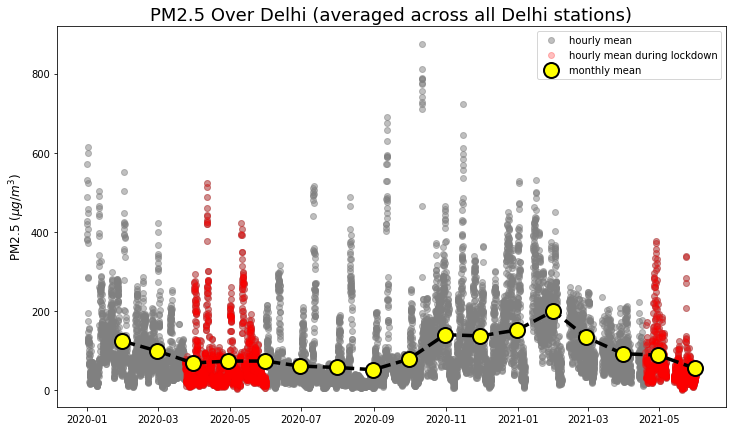

In [43]:
plotSpecies('PM2.5')

figure ready: Timeseries_PM10.tiff


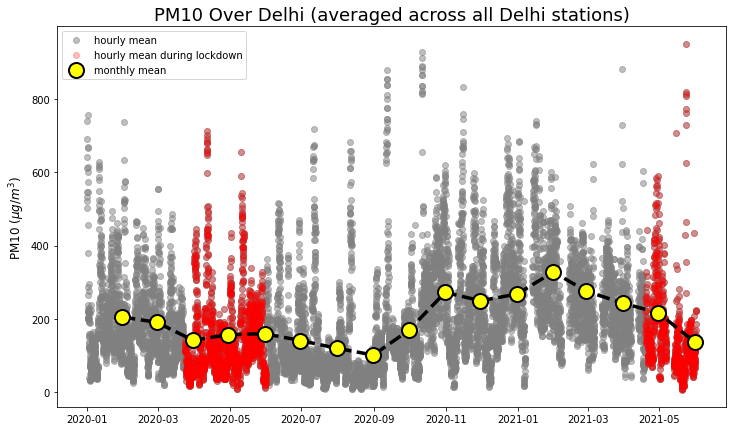

In [44]:
plotSpecies('PM10')

figure ready: Timeseries_NO2.tiff


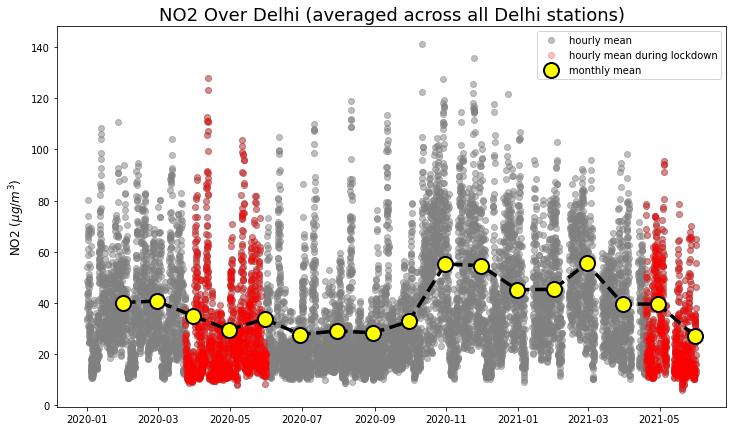

In [45]:
plotSpecies('NO2')

figure ready: Timeseries_SO2.tiff


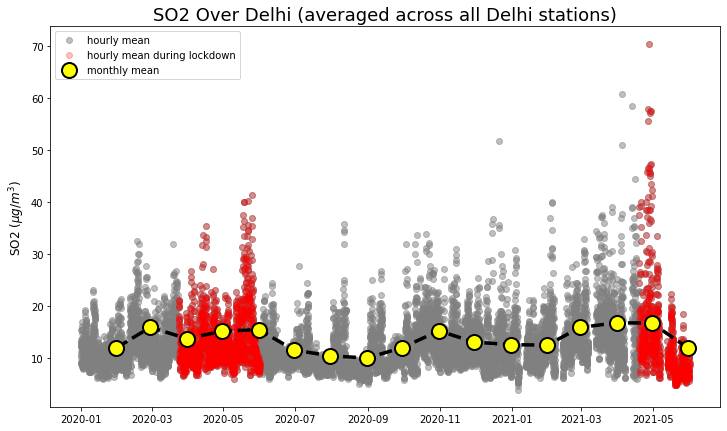

In [46]:
plotSpecies('SO2')

figure ready: Timeseries_MDA8 Ozone.tiff


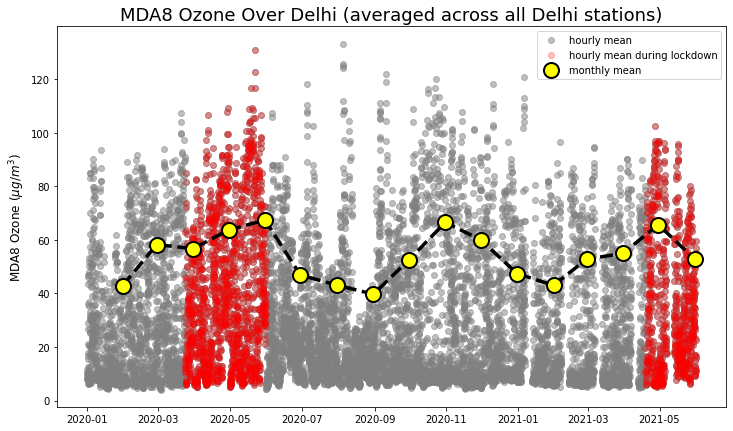

In [47]:
plotSpecies('Ozone')

102


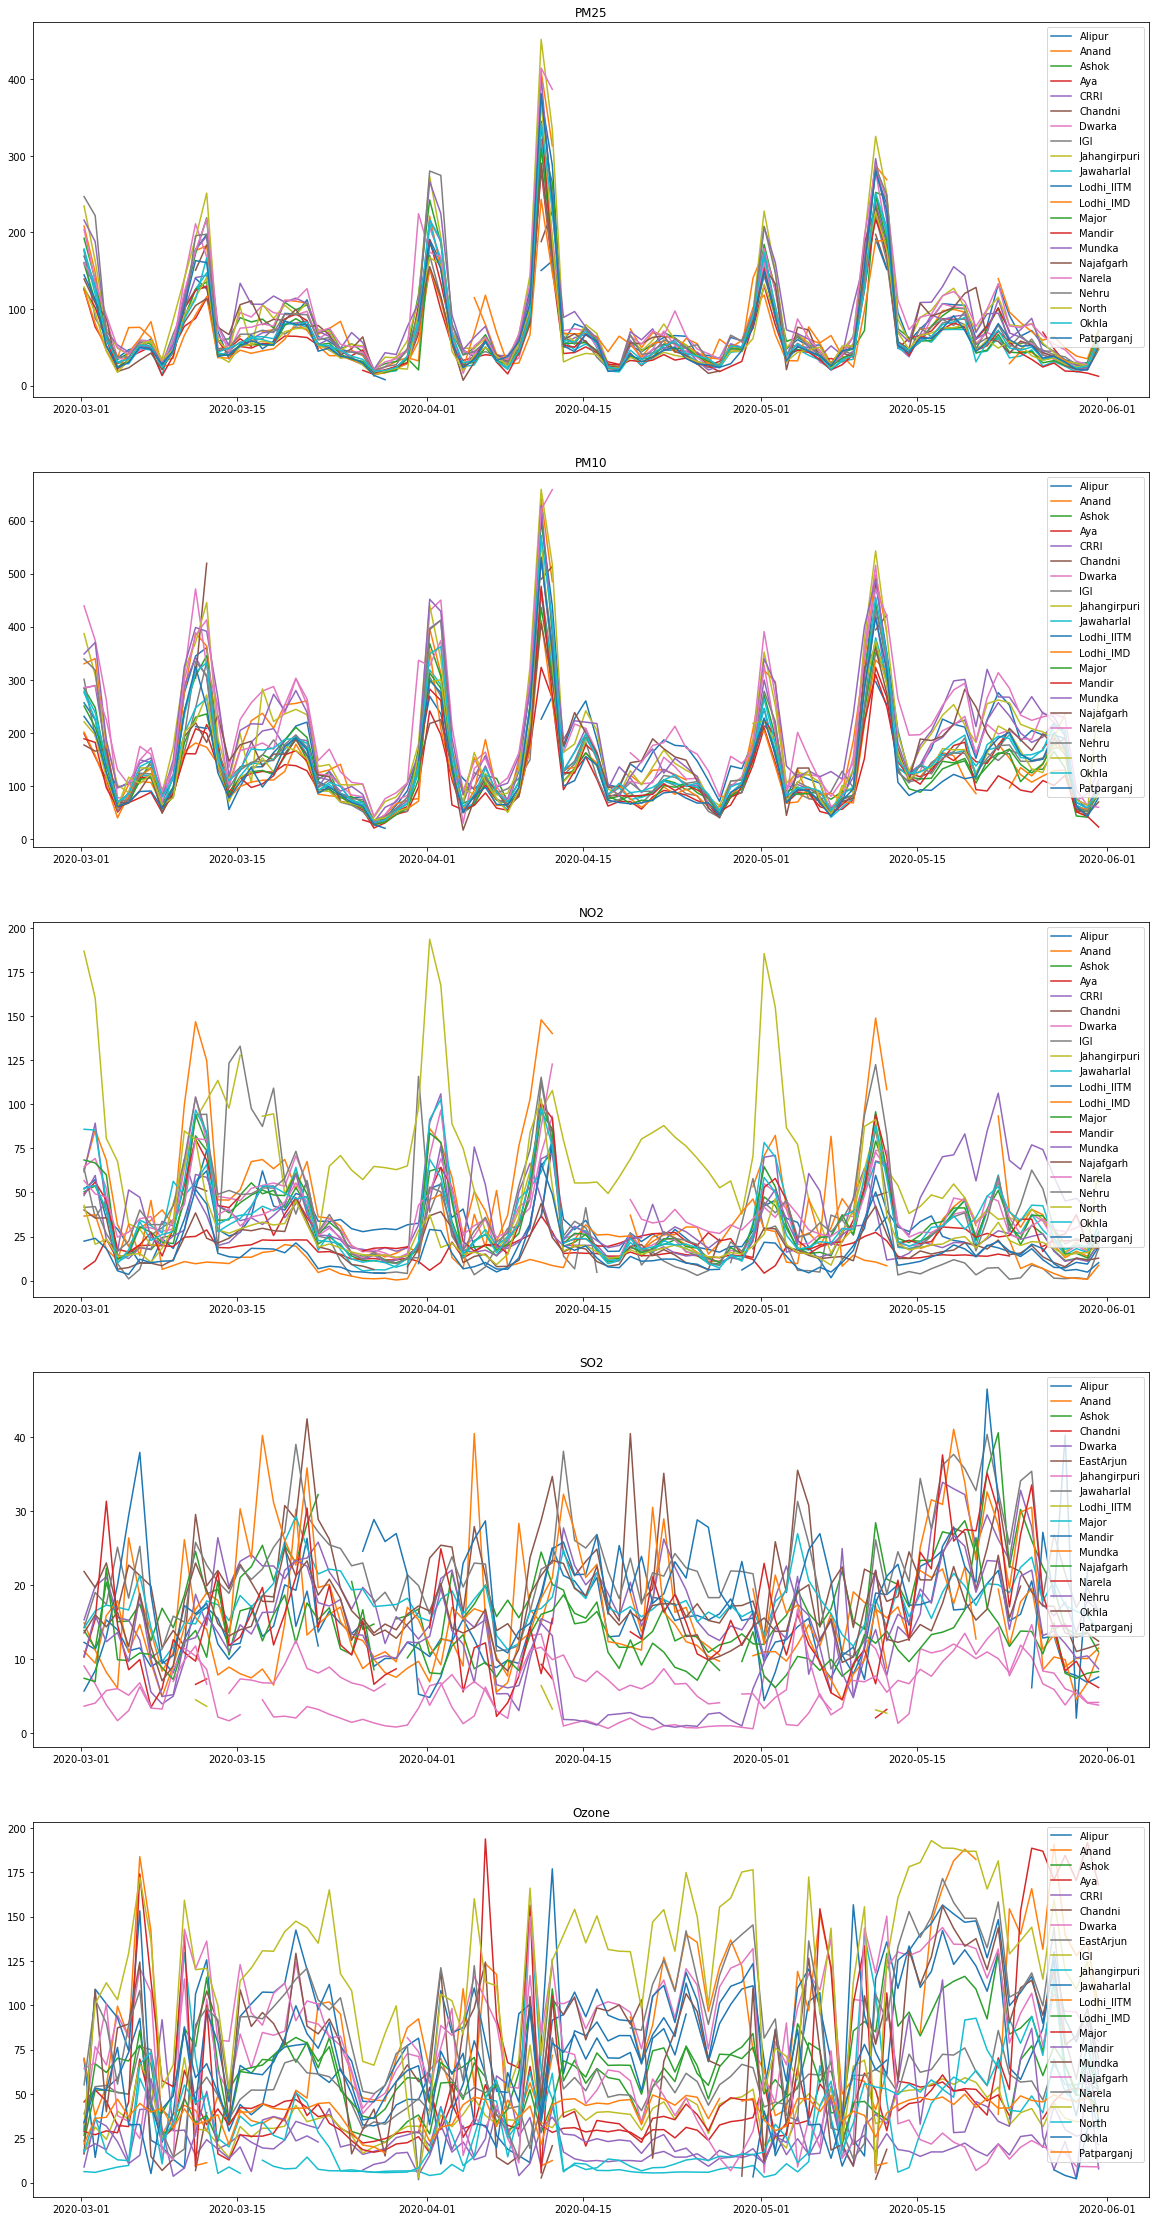

In [100]:
fig, axs = plt.subplots(5, figsize=(20, 40))
count = 0
ahead = list(station_data.keys())[:30]
skip = ['ITO', 'IHBAS', 'Punjabi', 'Pusa_DPCC', 'NSIT', 'Bawana', 'Karni', 'DTU']
species = ['PM25', 'PM10', 'NO2', 'SO2', 'Ozone']
for station in station_data:
    for ax, pollutant in zip(axs, species):
        if not station in ahead:
            continue
        if station in skip:
            continue
        if pollutant in station_data[station]['daily'].columns:
            ax.plot(station_data[station]['daily'][pollutant].loc['2020-03':'2020-05'], label=station)
            count += 1
        ax.legend()
        ax.set_title(pollutant)
print(count)